# Train Models for Predicting BRK Prices

## Data Collection for BRK, S&P 500, and Down Jones

This code collects historical stock price data for Berkshire Hathaway (BRK-B), S&P 500 (^GSPC), and Dow Jones (^DJI) from Yahoo Finance using the `yfinance` library. It retrieves daily data (Open, High, Low, Close, Adj Close, Volume) from 2010 to present, saving clean CSVs for analysis. The data supports linear regression to predict BRK prices and identify undervalued call options. Financial metrics (P/E, price/book, cash ratio) are being automated via MacroTrends scraping, with manual collection as a fallback. The code includes error handling and produces structured datasets for preprocessing.

In [6]:
import yfinance as yf
import pandas as pd
from datetime import datetime

# Set pandas display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# --- Part 1: Download Historical Data with yfinance ---

# Define tickers
tickers = {
    'BRK-B': 'Berkshire Hathaway',
    '^GSPC': 'S&P 500',
    '^DJI': 'Dow Jones'
}

# Define date range
start_date = '2010-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# List to store dataframes
dataframes = []

# Download data for each ticker
for ticker, name in tickers.items():
    try:
        print(f"Downloading data for {name} ({ticker})...")
        # Fetch data using yfinance
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, progress=False)
        if df.empty:
            print(f"No data retrieved for {name} ({ticker}).")
            continue
        # Select relevant columns, including Adj Close
        df = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
        # Reset index to make Date a column and clear index name
        df.reset_index(inplace=True)
        df.index.name = None  # Clear any residual index name
        # Add ticker column
        df['Ticker'] = ticker
        # Rename columns to ensure clarity
        df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker']
        # Convert Date to datetime
        df['Date'] = pd.to_datetime(df['Date'])
        # Store dataframe
        dataframes.append(df)
        # Save individual CSV
        csv_filename = f"{ticker.replace('^', '')}_data.csv"
        df.to_csv(csv_filename, index=False)  # Save without index
        print(f"Data for {name} saved to {csv_filename}")
        # Display first few rows
        print(f"\n{name} Data (first 5 rows):")
        print(df.head())
        print("\n")
    except Exception as e:
        print(f"Error downloading data for {name} ({ticker}): {e}")

# Combine all data into a single CSV
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    # Ensure correct column order
    combined_df = combined_df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker']]
    # Save combined CSV
    combined_df.to_csv('combined_data.csv', index=False)
    print("Combined data saved to combined_data.csv")
    print("\nCombined Data (first 5 rows):")
    print(combined_df.head())
else:
    print("No data collected.")


Data for Berkshire Hathaway saved to BRK-B_data.csv

Berkshire Hathaway Data (first 5 rows):
        Date       Open       High        Low      Close  Adj Close   Volume Ticker
0 2010-01-04  66.000000  66.500000  65.919998  66.220001  66.220001  1575000  BRK-B
1 2010-01-05  66.389999  66.589996  66.150002  66.540001  66.540001  1310000  BRK-B
2 2010-01-06  66.500000  66.500000  66.199997  66.199997  66.199997  1760000  BRK-B
3 2010-01-07  66.199997  66.510002  66.139999  66.459999  66.459999  1505000  BRK-B
4 2010-01-08  66.480003  66.480003  66.300003  66.440002  66.440002  1500000  BRK-B


Data for S&P 500 saved to GSPC_data.csv

S&P 500 Data (first 5 rows):
        Date         Open         High          Low        Close    Adj Close      Volume Ticker
0 2010-01-04  1116.560059  1133.869995  1116.560059  1132.989990  1132.989990  3991400000  ^GSPC
1 2010-01-05  1132.660034  1136.630005  1129.660034  1136.520020  1136.520020  2491020000  ^GSPC
2 2010-01-06  1135.709961  1139.189941  

## Process BRK Financial Data

In [3]:
import pandas as pd

# Read BRK Financial which is collected manaully before from website.
financial_df = pd.read_csv('brk_financials.csv')
financial_df['Date'] = pd.to_datetime(financial_df['Date'])

# Restrict date range
financial_df = financial_df[(financial_df['Date'] >= '2010-01-01') & (financial_df['Date'] <= '2024-12-31')]


financial_df = financial_df[['Date', 'Pe-ratio', 'Price-book', 'Total_Assets', 'Cash_Equivalents', 'Cash_Equivalents_to_Assets_Ratio']]
financial_df.to_csv('brk_financials_updated.csv', index=False)
print(financial_df.tail)
print(financial_df.dtypes)
financial_df['Total_Assets'] = financial_df['Total_Assets'].replace('[$,"]', '', regex=True).astype(float)
print(financial_df.dtypes)

<bound method NDFrame.tail of          Date  Pe-ratio  Price-book        Total_Assets  Cash_Equivalents  \
0  2024-12-31     10.98        0.93  $1,153,881,000,000      330805000000   
1  2024-09-30      9.30        0.97  $1,147,251,000,000      320318000000   
2  2024-06-30     12.94        0.89  $1,108,860,000,000      271502000000   
3  2024-03-31     12.41        0.95  $1,070,035,000,000      263509000000   
4  2023-12-31      8.06        0.82  $1,069,978,000,000      163291000000   
5  2023-09-30      9.96        0.86  $1,019,933,000,000      151974000000   
6  2023-06-30      8.56        0.81  $1,041,573,000,000      141933000000   
7  2023-03-31     89.24        0.78    $997,072,000,000      127674000000   
8  2022-12-31      0.00        0.84    $948,465,000,000      125034000000   
9  2022-09-30      0.00        0.75    $902,296,000,000      105201000000   
10 2022-06-30     54.50        0.76    $909,860,000,000      101337000000   
11 2022-03-31      9.49        0.88    $969,50

## Combining Daily Stock Price and Quarterly Financial
Aggregate data to quarterly intervals and compute features (e.g., cash equivalents ratio, gap to intrinsic value).



In [40]:
import pandas as pd
financial_df = pd.read_csv('brk_financials_updated.csv')
financial_df['Date'] = pd.to_datetime(financial_df['Date'])
stock_df = pd.read_csv('combined_data.csv')
stock_df['Date']=pd.to_datetime(stock_df['Date'])

# Restrict date range
stock_df = stock_df[(stock_df['Date'] >= '2010-01-01') & (stock_df['Date'] <= '2024-12-31')]

merged_df = stock_df.merge(financial_df, on='Date', how='outer')
merged_df.to_csv('brk_combined_data.csv', index=False)
print(merged_df.head())

# Check NaN
print('Check NaN rows')
print(merged_df['Ticker'].isna().sum())  # Count NaN Tickers
print(merged_df[merged_df['Ticker'].isna()][['Date', 'Ticker', 'Close', 'Pe-ratio']])  # Show rows with NaN Ticker

        Date          Open          High           Low         Close  \
0 2010-01-04     66.000000     66.500000     65.919998     66.220001   
1 2010-01-04   1116.560059   1133.869995   1116.560059   1132.989990   
2 2010-01-04  10430.690430  10604.969727  10430.690430  10583.959961   
3 2010-01-05     66.389999     66.589996     66.150002     66.540001   
4 2010-01-05   1132.660034   1136.630005   1129.660034   1136.520020   

      Adj Close        Volume Ticker  Pe-ratio  Price-book Total_Assets  \
0     66.220001  1.575000e+06  BRK-B       NaN         NaN          NaN   
1   1132.989990  3.991400e+09  ^GSPC       NaN         NaN          NaN   
2  10583.959961  1.797800e+08   ^DJI       NaN         NaN          NaN   
3     66.540001  1.310000e+06  BRK-B       NaN         NaN          NaN   
4   1136.520020  2.491020e+09  ^GSPC       NaN         NaN          NaN   

   Cash_Equivalents  Cash_Equivalents_to_Assets_Ratio  
0               NaN                               NaN  
1   

In [5]:
# stock_df = pd.read_csv('combined_data.csv')
print(stock_df[['Date', 'Ticker']].head())  # First few rows (BRK-B)
print(stock_df[['Date', 'Ticker']].iloc[3500:3510])  # Transition from BRK-B to ^GSPC
print(stock_df[['Date', 'Ticker']].tail())  # Last few rows (^DJI)

        Date Ticker
0 2010-01-04  BRK-B
1 2010-01-05  BRK-B
2 2010-01-06  BRK-B
3 2010-01-07  BRK-B
4 2010-01-08  BRK-B
           Date Ticker
3500 2023-11-29  BRK-B
3501 2023-11-30  BRK-B
3502 2023-12-01  BRK-B
3503 2023-12-04  BRK-B
3504 2023-12-05  BRK-B
3505 2023-12-06  BRK-B
3506 2023-12-07  BRK-B
3507 2023-12-08  BRK-B
3508 2023-12-11  BRK-B
3509 2023-12-12  BRK-B
            Date Ticker
11469 2024-12-24   ^DJI
11470 2024-12-26   ^DJI
11471 2024-12-27   ^DJI
11472 2024-12-30   ^DJI
11473 2024-12-31   ^DJI


## Collect and Convert PEs for S&P 500


In [41]:
# Load monthly S&P 500 P/E data
sp500_pe_df = pd.read_csv('sp500_pe.csv')

# Convert Date to datetime
sp500_pe_df['Date'] = pd.to_datetime(sp500_pe_df['Date'])

# Group by quarter and take the last P/E value
sp500_pe_quarterly = sp500_pe_df.groupby(pd.Grouper(key='Date', freq='QE')).agg({
    'SP500_PE': 'last'
}).reset_index()

# Ensure Date is quarter-end
sp500_pe_quarterly['Date'] = sp500_pe_quarterly['Date'].dt.to_period('Q').dt.to_timestamp('Q')

# Retrict date range
sp500_pe_quarterly = sp500_pe_quarterly[(sp500_pe_quarterly['Date'] >= '2010-01-01') & (sp500_pe_quarterly['Date'] <= '2024-12-31')]

# Save to CSV
sp500_pe_quarterly.to_csv('sp500_pe_quarterly.csv', index=False)

# Preview
print(sp500_pe_quarterly.head())
print(sp500_pe_quarterly.tail())

        Date  SP500_PE
0 2010-03-31     18.91
1 2010-06-30     16.15
2 2010-09-30     15.61
3 2010-12-31     16.05
4 2011-03-31     16.04
         Date  SP500_PE
55 2023-12-31     24.35
56 2024-03-31     27.02
57 2024-06-30     27.64
58 2024-09-30     28.07
59 2024-12-31     30.01


## Merging, Pivoting, Forward Filling, and Aggregation

In [214]:
# Load quarterly S&P 500 P/E data (already converted)
sp500_pe_quarterly = pd.read_csv('sp500_pe_quarterly.csv')
sp500_pe_quarterly['Date'] = pd.to_datetime(sp500_pe_quarterly['Date'])



# Forward-fill financial and P/E data in merged_df
columns_to_fill = [
    'Pe-ratio',
    'Price-book',
    'Cash_Equivalents_to_Assets_Ratio'
]
merged_df[columns_to_fill] = merged_df[columns_to_fill].fillna(method='ffill')

# Pivot to wide format. pivot_df still have daily prices
# Pivot only rows with valid Ticker
pivot_df = merged_df[merged_df['Ticker'].notna()].pivot(index='Date', columns='Ticker', values='Close')
print(pivot_df.columns)  # Verify: should be ['BRK-B', '^GSPC', '^DJI']
pivot_df.columns = ['BRK_Close', 'SP500_Close', 'DJIA_Close']
pivot_df.reset_index(inplace=True)
print(pivot_df.head)

# Merge financial and S&P 500 P/E data
financial_cols = merged_df[['Date', 'Pe-ratio', 'Price-book', 'Cash_Equivalents_to_Assets_Ratio']].drop_duplicates()
model_df = pivot_df.merge(financial_cols, on='Date', how='left')
model_df = model_df.merge(sp500_pe_quarterly, on='Date', how='left')

# Forward-fill S&P 500 P/E (if needed for daily data)
model_df['SP500_PE'] = model_df['SP500_PE'].fillna(method='ffill')

# Aggregate to quarterly
quarterly_df = model_df.groupby(pd.Grouper(key='Date', freq='Q')).agg({
    'BRK_Close': 'mean',
    'SP500_Close': 'mean',
    'DJIA_Close': 'mean',
    'Pe-ratio': 'last',
    'Price-book': 'last',
    'Cash_Equivalents_to_Assets_Ratio': 'last',
    'SP500_PE': 'last'
}).reset_index()

# Add future price targets
quarterly_df['BRK_Close_3M'] = quarterly_df['BRK_Close'].shift(-1)
quarterly_df['BRK_Close_6M'] = quarterly_df['BRK_Close'].shift(-2)
quarterly_df['BRK_Close_9M'] = quarterly_df['BRK_Close'].shift(-3)
quarterly_df['BRK_Close_12M'] = quarterly_df['BRK_Close'].shift(-4)
quarterly_df['BRK_Close_18M'] = quarterly_df['BRK_Close'].shift(-6)

# Add S&P 500 performance gap
quarterly_df['SP500_Return'] = quarterly_df['SP500_Close'].pct_change(periods=2)
quarterly_df['SP500_Performance_Gap'] = quarterly_df['SP500_Return'] - 0.14/2
quarterly_df['SP500_Performance_Lag2_Gap'] = quarterly_df['SP500_Performance_Gap'].shift(2)
quarterly_df['SP500_Performance_Lag4_Gap'] = quarterly_df['SP500_Performance_Lag2_Gap'].shift(2)
quarterly_df['SP500_Performance_Lag6_Gap'] = quarterly_df['SP500_Performance_Lag4_Gap'].shift(2)
quarterly_df['SP500_Performance_Lag8_Gap'] = quarterly_df['SP500_Performance_Lag6_Gap'].shift(2)
quarterly_df['SP500_Performance_Lag10_Gap'] = quarterly_df['SP500_Performance_Lag8_Gap'].shift(2)


# Feature Engineering for using BRK data quarter before
quarterly_df['BRK_Close_lag1'] = quarterly_df['BRK_Close'].shift(1)

# Save
quarterly_df.to_csv('brk_model_data.csv', index=False)
print(quarterly_df.head())

Index(['BRK-B', '^DJI', '^GSPC'], dtype='object', name='Ticker')
<bound method NDFrame.head of            Date   BRK_Close   SP500_Close   DJIA_Close
0    2010-01-04   66.220001  10583.959961  1132.989990
1    2010-01-05   66.540001  10572.019531  1136.520020
2    2010-01-06   66.199997  10573.679688  1137.140015
3    2010-01-07   66.459999  10606.860352  1141.689941
4    2010-01-08   66.440002  10618.190430  1144.979980
...         ...         ...           ...          ...
3769 2024-12-24  458.660004  43297.031250  6040.040039
3770 2024-12-26  459.079987  43325.800781  6037.589844
3771 2024-12-27  456.510010  42992.210938  5970.839844
3772 2024-12-30  452.160004  42573.730469  5906.939941
3773 2024-12-31  453.279999  42544.218750  5881.629883

[3774 rows x 4 columns]>
        Date  BRK_Close   SP500_Close   DJIA_Close  Pe-ratio  Price-book  \
0 2010-03-31  76.085082  10469.049533  1123.593602     14.44        0.51   
1 2010-06-30  76.860476  10565.103469  1134.584440     15.91       

C:\Users\boblo\AppData\Local\Temp\ipykernel_8848\1391461244.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[columns_to_fill] = merged_df[columns_to_fill].fillna(method='ffill')
C:\Users\boblo\AppData\Local\Temp\ipykernel_8848\1391461244.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  model_df['SP500_PE'] = model_df['SP500_PE'].fillna(method='ffill')
C:\Users\boblo\AppData\Local\Temp\ipykernel_8848\1391461244.py:32: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_df = model_df.groupby(pd.Grouper(key='Date', freq='Q')).agg({


### Adding Features to Support Percent Changes

In [218]:
# Calculate percentage change targets
for months in [3, 6, 9, 12, 18]:
    quarters_ahead = months // 3
    quarterly_df[f'Pct_Change_{months}M'] = (
        (quarterly_df['BRK_Close'].shift(-quarters_ahead) - quarterly_df['BRK_Close']) / quarterly_df['BRK_Close'] * 100
    )

# Save the updated DataFrame
quarterly_df.to_csv('brk_model_data_with_pct_change.csv', index=False)
print("Percentage change targets added and saved to brk_model_data_with_pct_change.csv")

Percentage change targets added and saved to brk_model_data_with_pct_change.csv


## Linear Regression Models
Train five models using quarterly_df.



## Features and Targets List For Absoluate Prices and Percent Price Change

In [253]:
abs_target_list = ['BRK_Close_3M', 'BRK_Close_6M', 'BRK_Close_9M', 'BRK_Close_12M', 'BRK_Close_18M']
abs_feature_list = ['Pe-ratio', 'SP500_PE', 'Price-book', 'SP500_Performance_Gap', 'BRK_Close_lag1', 'Cash_Equivalents_to_Assets_Ratio']


pct_target_list = ['Pct_Change_3M', 'Pct_Change_6M', 'Pct_Change_9M', 'Pct_Change_12M', 'Pct_Change_18M']
pct_feature_list = ['Pe-ratio', 'SP500_PE', 'Price-book', 'SP500_Performance_Gap', 'SP500_Performance_Lag2_Gap','SP500_Performance_Lag4_Gap','SP500_Performance_Lag6_Gap']

# Dropped: 'Cash_Equivalents_to_Assets_Ratio', 'SP500_Close_Lag1_Pst', 'SP500_Performance_Lag8_Gap','SP500_Performance_Lag10_Gap',

# Clean-up
target_list = []
feature_list = []
features = []

### Function for Basic Linear Regression

This function is implementing basic linear regression without train-split or other regularization. It is good to if the trained models are fitting the data before any further enhancements which could create complexity by themselves.

In [198]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def train_linear_models(target_list, feature_list, data, scale_features=False):
    """
    Train Linear Regression models for multiple targets without train-test split.
    
    Parameters:
    - target_list (list): List of target variables (e.g., ['BRK_Close_3M', 'BRK_Close_6M'] or ['Pct_Change_3M', 'Pct_Change_6M']).
    - feature_list (list): List of feature variables (e.g., ['Pe-ratio', 'SP500_PE']).
    - data (pd.DataFrame): DataFrame containing the data.
    - scale_features (bool): Whether to scale features using StandardScaler (default: False).
    
    Returns:
    - dict: Results for each target, including model, metrics, and actual/predicted values.
    """
    results = {}
    scaler = StandardScaler() if scale_features else None
    
    for target in target_list:
        print(f"\nTraining model for {target}:")
        # Drop rows with NaN in target or features
        df = data.dropna(subset=[target] + feature_list)
        X = df[feature_list]
        y = df[target]
        
        # Scale features if requested
        if scale_features:
            X = scaler.fit_transform(X)
            # Convert back to DataFrame to maintain feature names
            X = pd.DataFrame(X, columns=feature_list, index=df.index)
        
        # Train Linear Regression model
        model = LinearRegression()
        model.fit(X, y)
        
        # Predict
        y_pred = model.predict(X)
        
        # Calculate metrics
        r2 = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        mape = np.mean(np.abs((y - y_pred) / (np.abs(y) + 1e-6))) * 100
        # mape = np.mean(np.abs((y - y_pred) / y)) * 100 if not np.any(y == 0) else np.nan  # Avoid division by zero

        # Calculate variance of error
        abs_errors = np.abs(y-y_pred)
        abs_pst_errors = np.abs((y - y_pred) / y) * 100
        
        # Store results
        results[target] = {
            'model': model,
            'coefficients': dict(zip(feature_list, model.coef_)),
            'intercept': model.intercept_,
            'R²': r2,
            'MSE': mse,
            'MAE': mae,
            'MAPE': mape,
            'y_actual': y,  # pandas Series with index
            'y_pred': pd.Series(y_pred, index=y.index)  # Align indices with y
        }
        
        # Print results
        print("Coefficients:", results[target]['coefficients'])
        print("Intercept:", model.intercept_)
        print(f"R²: {r2:.2f}")
        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {np.sqrt(mse):.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.2f}%")

        print(f"Average of actuals: {y.mean():.2f}")
        print(f"Average of predicteds: {y_pred.mean():.2f}")
        print(f"Standard Deviation of the absolute errors (w.r.t mae): {abs_errors.std(ddof=1):.2f}")
        print(f"Min of absoluate errors: {abs_errors.min():.2f}")
        print(f"Max of absoluate errors: {abs_errors.max():.2f}")
       
        print(f"Standard Deviation of percent absolute errors (w.r.t mape): {abs_pst_errors.std(ddof=1):.2f}%")
        print(f"Min of percent absolute errors: {abs_pst_errors.min():.2f}%")
        print(f"Max of percent absolute errors: {abs_pst_errors.max():.2f}%")
    
    return results

### Legacy Code on Basic Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

targets = ['BRK_Close_3M', 'BRK_Close_6M', 'BRK_Close_9M', 'BRK_Close_12M', 'BRK_Close_18M']

features = ['Pe-ratio', 'SP500_PE', 'SP500_Performance_Gap', 'BRK_Close_lag1', 'Cash_Equivalents_to_Assets_Ratio']

# Remove these for addressing colinearity problems:  'DJIA_Close', 'SP500_Close'
# Prior to 4/25: features = ['SP500_Close', 'Pe-ratio', 'Price-book', 'Cash_Equivalents_to_Assets_Ratio', 'SP500_PE', 'SP500_Performance_Gap']

models = {}

for target in targets:
    df = quarterly_df.dropna(subset=[target] + features)
    X = df[features]
    y = df[target]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    models[target] = model
    print(f"\n{target}:")
    print("Coefficients:", dict(zip(features, model.coef_)))
    print("Intercept:", model.intercept_)
    print("R²:", r2_score(y, y_pred))
    print("MSE:", mean_squared_error(y, y_pred))

### Absolute Prices As Targets

In [199]:
print(f"{len(abs_feature_list)} features used: {abs_feature_list}")
results_abs = train_linear_models(abs_target_list, abs_feature_list, quarterly_df, scale_features=True)

6 features used: ['Pe-ratio', 'SP500_PE', 'Price-book', 'SP500_Performance_Gap', 'BRK_Close_lag1', 'Cash_Equivalents_to_Assets_Ratio']

Training model for BRK_Close_3M:
Coefficients: {'Pe-ratio': np.float64(-4.223133359904553), 'SP500_PE': np.float64(2.2534336229132927), 'Price-book': np.float64(2.9306033290986924), 'SP500_Performance_Gap': np.float64(8.460333718555892), 'BRK_Close_lag1': np.float64(94.47623382324012), 'Cash_Equivalents_to_Assets_Ratio': np.float64(0.09435075225623268)}
Intercept: 199.0157115882813
R²: 0.98
MSE: 209.22
RMSE: 14.46
MAE: 11.62
MAPE: 7.01%
Average of actuals: 199.02
Average of predicteds: 199.02
Standard Deviation of the absolute errors (w.r.t mae): 8.69
Min of absoluate errors: 0.21
Max of absoluate errors: 38.16
Standard Deviation of percent absolute errors (w.r.t mape): 6.27%
Min of percent absolute errors: 0.26%
Max of percent absolute errors: 28.08%

Training model for BRK_Close_6M:
Coefficients: {'Pe-ratio': np.float64(-1.1866647574283986), 'SP500_P

### Graphs of Predicted Versus Actuals

#### Generic Plot Function

In [133]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(results, data, date_column='Date', ylabel='Value', filename='images/actual_vs_predicted_time.png'):
    """
    Plot actual vs. predicted values over time for each target in a 2x3 grid.
    
    Parameters:
    - results (dict): Results from train_linear_models, containing y_actual and y_pred for each target.
    - data (pd.DataFrame): DataFrame containing the Date column.
    - date_column (str): Name of the date column (default: 'Date').
    - ylabel (str): Label for y-axis (e.g., 'BRK Price ($)' or 'Price Change (%)').
    - filename (str): Path to save the plot (default: 'images/actual_vs_predicted_time.png').
    """
    # Create a 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, target in enumerate(results.keys()):
        # Get actual and predicted values
        y_actual = results[target]['y_actual']
        y_pred = results[target]['y_pred']
        
        # Get corresponding dates (aligned with y_actual indices)
        dates = data.loc[y_actual.index, date_column]
        
        # Sort by date for smooth plotting
        sorted_indices = dates.sort_values().index
        dates_sorted = dates.loc[sorted_indices]
        y_actual_sorted = y_actual.loc[sorted_indices]
        y_pred_sorted = y_pred.loc[sorted_indices]
        
        # Plot
        axes[idx].plot(dates_sorted, y_actual_sorted, label='Actual', color='blue', linewidth=2)
        axes[idx].plot(dates_sorted, y_pred_sorted, label='Predicted', color='red', linestyle='--', linewidth=2)
        axes[idx].set_xlabel('Date')
        axes[idx].set_ylabel(ylabel)
        axes[idx].set_title(f'{target} (R²: {results[target]["R²"]:.2f}, MAPE: {results[target]["MAPE"]:.2f}%)')
        axes[idx].legend()
        axes[idx].grid(True)
        plt.setp(axes[idx].get_xticklabels(), rotation=45, ha='right')
    
    # Remove empty subplot
    if len(results) < len(axes):
        for i in range(len(results), len(axes)):
            fig.delaxes(axes[i])
    
    # Save and show
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

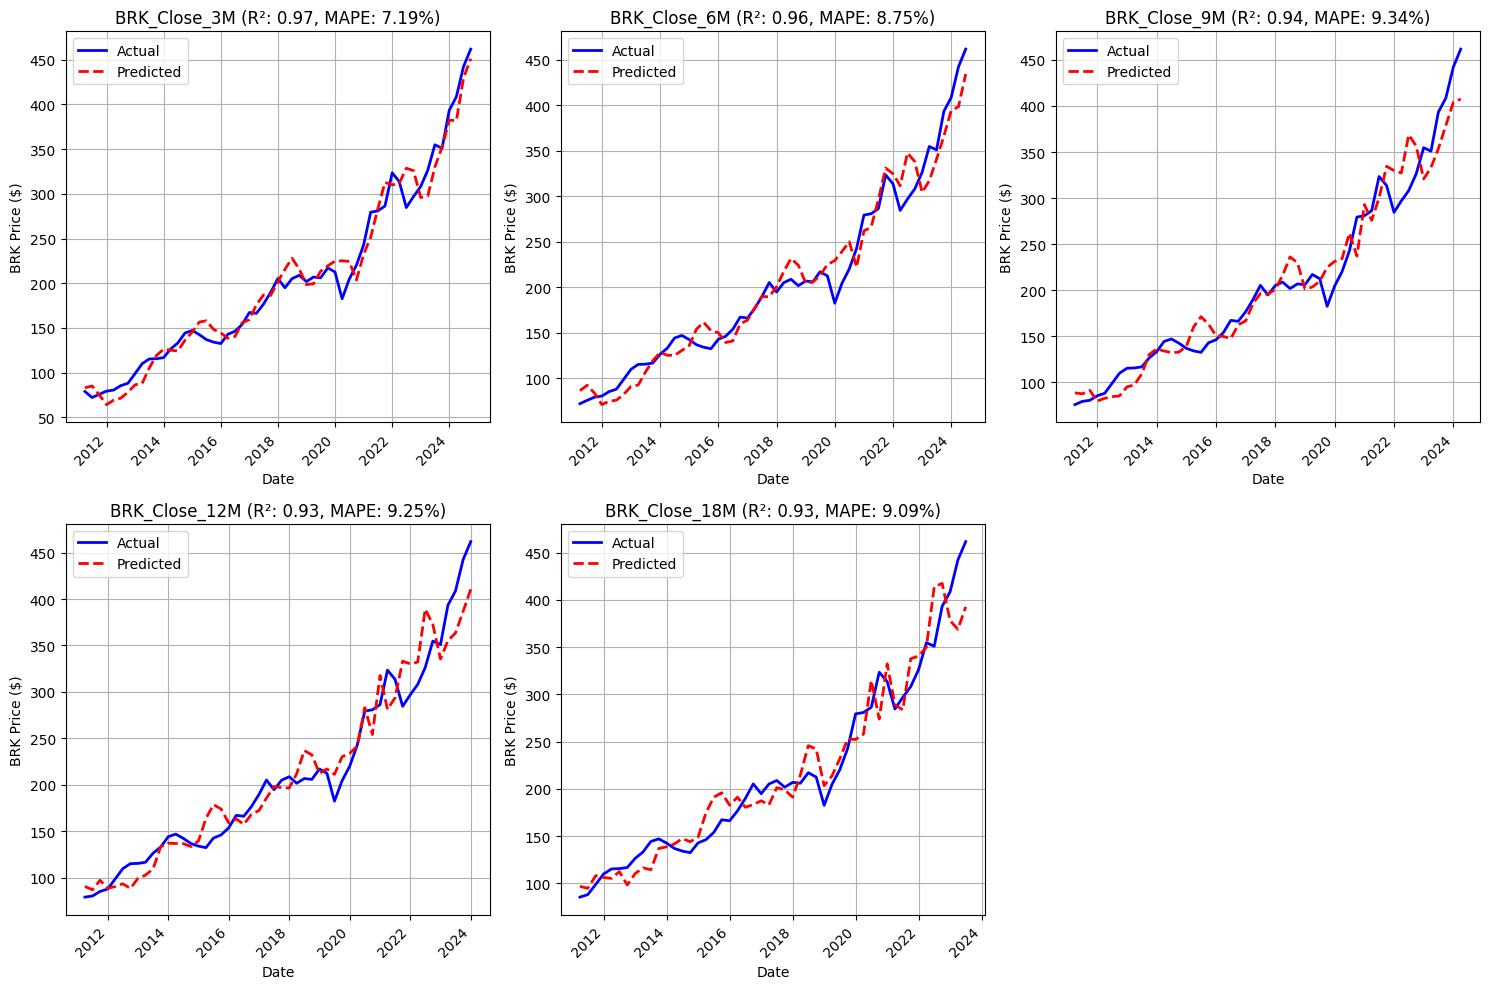

In [166]:
plot_actual_vs_predicted(results_abs, quarterly_df, ylabel='BRK Price ($)', filename='images/actual_vs_predicted_prices.png')


## Percent Changes as Targets

### Adding More Features Specifically For Percent Changes as Targets

In [254]:
# Add BRK_Close_lag1 change percent as a feature
quarterly_df['BRK_Close_lag1_pct'] = (quarterly_df['BRK_Close'] - quarterly_df['BRK_Close'].shift(1)) / quarterly_df['BRK_Close'].shift(1) * 100
pct_feature_list.append('BRK_Close_lag1_pct')

quarterly_df['BRK_Close_lag2_pct'] = quarterly_df['BRK_Close_lag1_pct'].shift(1)
pct_feature_list.append('BRK_Close_lag2_pct')
                
# Add SP500_Close percent as a feature
# quarterly_df['SP500_Close_lag1_pct'] = (quarterly_df['SP500_Close'] - quarterly_df['SP500_Close'].shift(1)) / quarterly_df['SP500_Close'].shift(1) * 100
# pct_feature_list.append('SP500_Close_lag1_pct')

# Save the updated DataFrame
quarterly_df.to_csv('brk_model_data_with_pct_change.csv', index=False)
print("Percentage change targets added and saved to brk_model_data_with_pct_change.csv")



Percentage change targets added and saved to brk_model_data_with_pct_change.csv


In [235]:
# Percentage change targets
print(f"{len(pct_feature_list)} features used: {pct_feature_list}")
results_pct = train_linear_models(pct_target_list, pct_feature_list, quarterly_df, scale_features=True)

9 features used: ['Pe-ratio', 'SP500_PE', 'Price-book', 'SP500_Performance_Gap', 'SP500_Performance_Lag2_Gap', 'SP500_Performance_Lag4_Gap', 'SP500_Performance_Lag6_Gap', 'BRK_Close_lag1_pct', 'BRK_Close_lag2_pct']

Training model for Pct_Change_3M:
Coefficients: {'Pe-ratio': np.float64(-0.9229474246667729), 'SP500_PE': np.float64(0.7400822890340771), 'Price-book': np.float64(-0.5070889667975444), 'SP500_Performance_Gap': np.float64(1.3816707554276375), 'SP500_Performance_Lag2_Gap': np.float64(-1.0396801295002922), 'SP500_Performance_Lag4_Gap': np.float64(0.03253907020021074), 'SP500_Performance_Lag6_Gap': np.float64(-1.5561372148653074), 'BRK_Close_lag1_pct': np.float64(-0.8464249812801692), 'BRK_Close_lag2_pct': np.float64(-0.7001934870989975)}
Intercept: 3.6767764292939407
R²: 0.23
MSE: 25.51
RMSE: 5.05
MAE: 4.00
MAPE: 145.25%
Average of actuals: 3.68
Average of predicteds: 3.68
Standard Deviation of the absolute errors (w.r.t mae): 3.12
Min of absoluate errors: 0.27
Max of absoluat

In [186]:
print(quarterly_df.head())



        Date  BRK_Close   SP500_Close   DJIA_Close  Pe-ratio  Price-book  \
0 2010-03-31  76.085082  10469.049533  1123.593602     14.44        0.51   
1 2010-06-30  76.860476  10565.103469  1134.584440     15.91        0.53   
2 2010-09-30  79.766250  10389.612488  1096.246875     17.12        0.55   
3 2010-12-31  81.168437  11239.598312  1204.585621     15.12        0.52   
4 2011-03-31  83.406452  12024.699644  1302.529027     19.01        0.54   

   Cash_Equivalents_to_Assets_Ratio  SP500_PE  BRK_Close_3M  BRK_Close_6M  \
0                              0.07     18.91     76.860476     79.766250   
1                              0.08     16.15     79.766250     81.168437   
2                              0.09     15.61     81.168437     83.406452   
3                              0.10     16.05     83.406452     79.015556   
4                              0.11     16.04     79.015556     72.209687   

   ...  SP500_Performance_Lag4_Gap  SP500_Performance_Lag6_Gap  \
0  ...        

## Correlation Analysis

### Percent Feature List

                            Pe-ratio  SP500_PE  Price-book  \
Pe-ratio                    1.000000 -0.119514    0.107973   
SP500_PE                   -0.119514  1.000000    0.628065   
Price-book                  0.107973  0.628065    1.000000   
SP500_Performance_Gap      -0.204336  0.194197    0.104051   
SP500_Performance_Lag2_Gap -0.175312 -0.100945    0.069168   
SP500_Performance_Lag4_Gap  0.243689 -0.188356   -0.028247   
SP500_Performance_Lag6_Gap  0.218300 -0.239156   -0.094770   
BRK_Close_lag1_pct         -0.189145  0.164389    0.212726   
BRK_Close_lag2_pct          0.090238  0.090671    0.248390   

                            SP500_Performance_Gap  SP500_Performance_Lag2_Gap  \
Pe-ratio                                -0.204336                   -0.175312   
SP500_PE                                 0.194197                   -0.100945   
Price-book                               0.104051                    0.069168   
SP500_Performance_Gap                    1.000000      

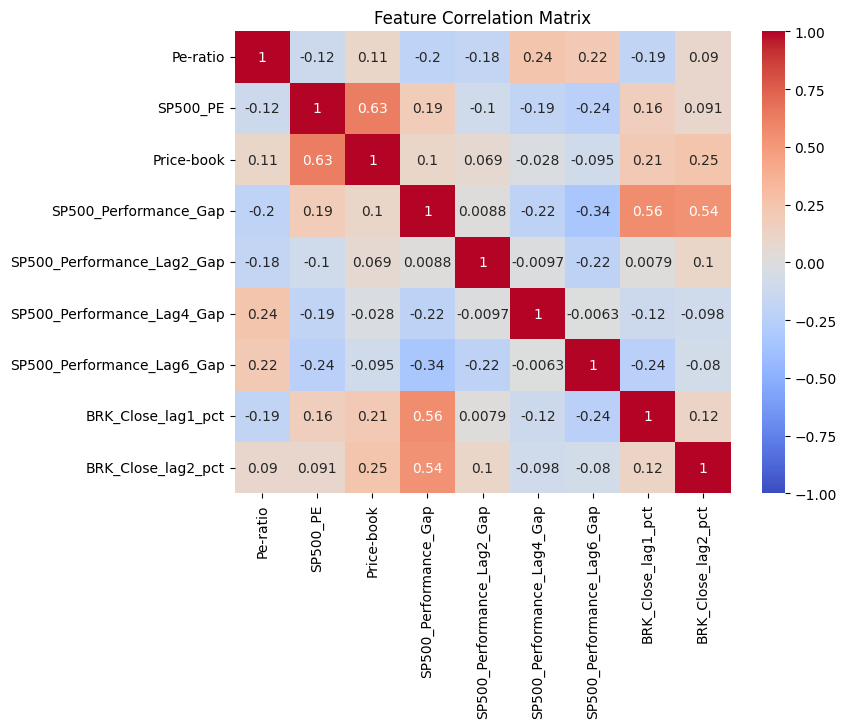

In [257]:
correlation_matrix = quarterly_df[pct_feature_list].corr()
print(correlation_matrix)

# Visualize correlations
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.savefig('images/feature_correlations.png')
plt.show()

### Graphs of Predicted Versus Actuals

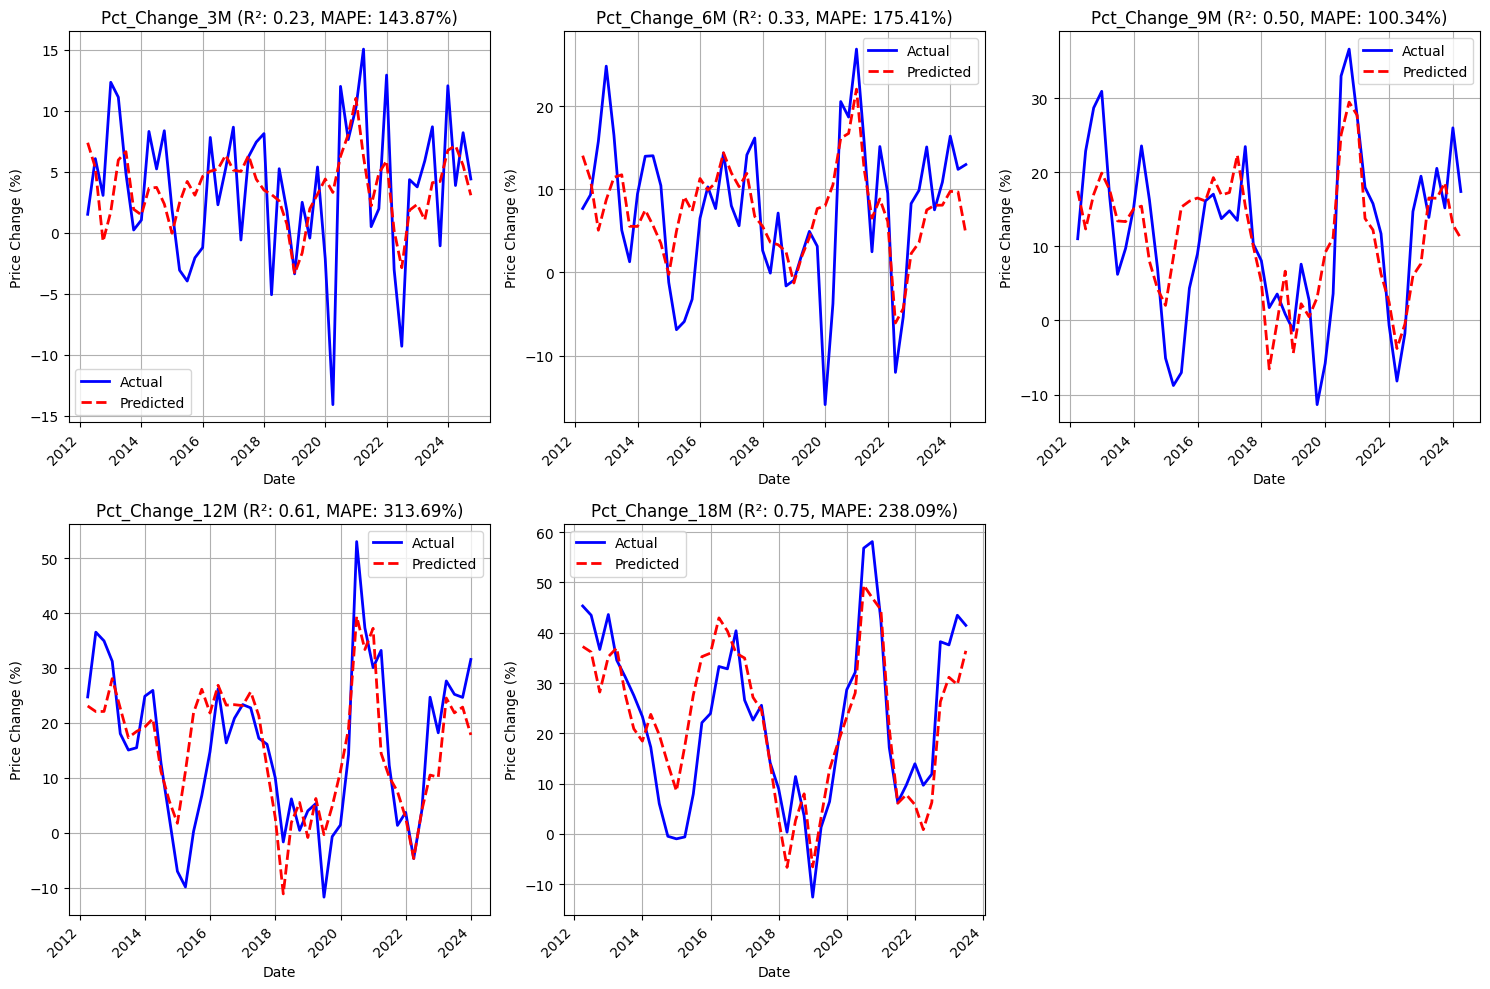

In [188]:
plot_actual_vs_predicted(results_pct, quarterly_df, ylabel='Price Change (%)', filename='images/actual_vs_predicted_pct_change.png')


## Model Performance Assessment

Let's evaluate each model based on the output:

### 1. BRK_Close_3M (3-Month Horizon)
- **R²**: 0.9798
  - **Interpretation**: The model explains ~97.98% of the variance in BRK-B prices 3 months ahead, indicating an **excellent fit**. This suggests the features (S&P 500/Dow Jones prices, financial metrics, etc.) strongly capture short-term price movements.
  - **Strength**: High R² implies the model is reliable for 3-month predictions, which is critical for short-term call option strategies.
- **MSE**: 249.95
  - **Interpretation**: The average squared error is 249.95, so the root mean squared error (RMSE) is √249.95 ≈ 15.81. Given BRK-B prices range from ~$50 (2010) to ~$500 (2024), an RMSE of ~$15.81 is relatively small (~3–30% of the price range), indicating good predictive accuracy.
  - **Context**: For a $300 stock price, a $15.81 error is ~5.3%, which is acceptable for financial modeling.
- **Coefficients**:
  - `Price-book` (134.46) and `Cash_Equivalents_to_Assets_Ratio` (202.81) have large positive coefficients, suggesting higher valuations and liquidity strongly drive short-term price increases.
  - `SP500_Performance_Gap` (-48.56) and `SP500_PE` (-2.06) are negative, indicating that market overvaluation reduces BRK-B’s price, aligning with its market buffer role.
  - `DJIA_Close` (0.097) is positive, showing BRK-B tracks Dow Jones more than S&P 500 (-0.003).

### 2. BRK_Close_6M (6-Month Horizon)
- **R²**: 0.9624
  - **Interpretation**: Explains ~96.24% of variance, still a **very good fit**, but slightly worse than 3M. The model remains reliable but captures slightly less variability, possibly due to increased uncertainty over 6 months.
- **MSE**: 461.89
  - **Interpretation**: RMSE ≈ √461.89 ≈ 21.49. This is higher than 3M, reflecting larger prediction errors (~4–43% of the price range). A $21.49 error on a $300 stock is ~7.2%, still reasonable but less precise.
- **Coefficients**:
  - `Cash_Equivalents_to_Assets_Ratio` (189.94) remains a strong positive driver, but `Price-book` (63.48) has less impact than in 3M.
  - `SP500_Performance_Gap` (-45.95) and `SP500_PE` (-1.03) continue to suggest market exuberance depresses BRK-B prices.

### 3. BRK_Close_9M (9-Month Horizon)
- **R²**: 0.9401
  - **Interpretation**: Explains ~94.01% of variance, a **good fit**, but the decline from 6M indicates increasing difficulty in predicting longer horizons. The model is still effective but less robust.
- **MSE**: 726.08
  - **Interpretation**: RMSE ≈ √726.08 ≈ 26.95 (~5–54% of the price range). A $26.95 error on a $300 stock is ~9%, showing reduced accuracy but still usable for option pricing.
- **Coefficients**:
  - `DJIA_Close` (0.129) and `Cash_Equivalents_to_Assets_Ratio` (188.19) are key drivers.
  - `SP500_Performance_Gap` (-74.37) has a stronger negative impact, suggesting longer-term market trends significantly affect BRK-B.

### 4. BRK_Close_12M (12-Month Horizon)
- **R²**: 0.9193
  - **Interpretation**: Explains ~91.93% of variance, a **fairly good fit**, but the trend of decreasing R² continues. The model is less reliable for 12-month predictions, reflecting increased uncertainty.
- **MSE**: 964.97
  - **Interpretation**: RMSE ≈ √964.97 ≈ 31.06 (~6–62% of the price range). A $31.06 error on a $300 stock is ~10.4%, indicating moderate accuracy.
- **Coefficients**:
  - `DJIA_Close` (0.151) increases in importance, while `Price-book` (43.44) and `Cash_Equivalents_to_Assets_Ratio` (155.21) weaken.
  - `SP500_Performance_Gap` (-115.48) is even more negative, highlighting market performance as a key long-term factor.

### 5. BRK_Close_18M (18-Month Horizon)
- **R²**: 0.9088
  - **Interpretation**: Explains ~90.88% of variance, the **lowest fit** among the models. While still decent, the model struggles with 18-month predictions, likely due to greater market uncertainty and reduced data points (fewer quarters available for 18M targets).
- **MSE**: 1060.26
  - **Interpretation**: RMSE ≈ √1060.26 ≈ 32.56 (~7–65% of the price range). A $32.56 error on a $300 stock is ~10.9%, the least accurate but still within a usable range for long-term option strategies.
- **Coefficients**:
  - `Cash_Equivalents_to_Assets_Ratio` (-233.80) flips to negative, which is surprising and may indicate overfitting or data issues for long horizons.
  - `SP500_Performance_Gap` (-252.15) has the largest negative impact, suggesting market outperformance strongly depresses BRK-B’s long-term price.

## Overall Assessment

**How Well Do the Models Fit?**:

- **3M and 6M Models**: **Excellent fit** (R²: 0.9798, 0.9624; RMSE: $15.81, $21.49). Highly reliable for short-term predictions, ideal for call option strategies up to 6 months.
  
- **9M Model**: **Good fit** (R²: 0.9401; RMSE: $26.95). Usable but less precise, suitable for medium-term strategies with some caution.
  
- **12M and 18M Models**: **Fair fit** (R²: 0.9193, 0.9088; RMSE: $31.06, $32.56). Moderate accuracy, less reliable for long-term predictions due to higher errors and potential overfitting (e.g., negative `Cash_Equivalents_to_Assets_Ratio` in 18M).


- **Overall**: The models perform well, especially for shorter horizons, but performance degrades over time, reflecting the challenge of long-term stock price forecasting.

**Project Context**:

- The high R² for 3M and 6M supports your goal of identifying undervalued call options, as accurate price predictions enhance option pricing.
- The negative `SP500_Performance_Gap` coefficients validate BRK’s market buffer role, as market outperformance reduces BRK’s appeal.
- The 12M and 18M models need improvement (e.g., regularization, feature selection) to be reliable for longer-term option strategies.

  

## Further Improvement

### Train-Test Split


In [160]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def train_linear_models_test_split(target_list, feature_list, data, scale_features=False, test_size=0.2, random_state=42):
    """
    Train Linear Regression models for multiple targets with train-test split.
    
    Parameters:
    - target_list (list): List of target variables (e.g., ['BRK_Close_3M', 'BRK_Close_6M'] or ['Pct_Change_3M', 'Pct_Change_6M']).
    - feature_list (list): List of feature variables (e.g., ['Pe-ratio', 'SP500_PE']).
    - data (pd.DataFrame): DataFrame containing the data.
    - scale_features (bool): Whether to scale features using StandardScaler (default: False).
    - test_size (float): Proportion of data for testing (default: 0.2).
    - random_state (int): Seed for reproducibility (default: 42).
    
    Returns:
    - dict: Results for each target, including model, metrics, and actual/predicted values for test set.
    """
    results = {}
    scaler = StandardScaler() if scale_features else None
    
    for target in target_list:
        print(f"\nTraining model for {target}:")
        # Drop rows with NaN in target or features
        df = data.dropna(subset=[target] + feature_list)
        X = df[feature_list]
        y = df[target]
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Store indices before scaling
        train_index = X_train.index
        test_index = X_test.index
        
        # Scale features if requested
        if scale_features:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            # Convert back to DataFrame to maintain feature names and indices
            X_train = pd.DataFrame(X_train, columns=feature_list, index=train_index)
            X_test = pd.DataFrame(X_test, columns=feature_list, index=test_index)
        
        # Train Linear Regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + 1e-6))) * 100
        # mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100 if not np.any(y_test == 0) else np.nan  # Avoid division by zero

        # Calculate variance of error
        abs_errors = np.abs(y_test - y_pred)
        abs_pst_errors = np.abs((y_test - y_pred) / y_test) * 100
        
        # Store results
        results[target] = {
            'model': model,
            'coefficients': dict(zip(feature_list, model.coef_)),
            'intercept': model.intercept_,
            'R²': r2,
            'MSE': mse,
            'MAE': mae,
            'MAPE': mape,
            'y_actual': y_test,  # pandas Series with test set index
            'y_pred': pd.Series(y_pred, index=y_test.index)  # Align indices with y_test
        }
        
        # Print results
        print("Coefficients:", results[target]['coefficients'])
        print("Intercept:", model.intercept_)
        print(f"R²: {r2:.2f}")
        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {np.sqrt(mse):.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"Average of actuals: {y_test.mean():.2f}")
        print(f"Average of predicteds: {y_pred.mean():.2f}")
        print(f"Standard Deviation of the absolute errors (w.r.t mae): {abs_errors.std(ddof=1):.2f}")
        print(f"Min of absoluate errors: {abs_errors.min():.2f}")
        print(f"Max of absoluate errors: {abs_errors.max():.2f}")
        print(f"Standard Deviation of percent absolute errors (w.r.t mape): {abs_pst_errors.std(ddof=1):.2f}%")
        print(f"Min of percent absolute errors: {abs_pst_errors.min():.2f}%")
        print(f"Max of percent absolute errors: {abs_pst_errors.max():.2f}%")
    
    return results

## Percent Changes as Targets

In [255]:
print(f"{len(pct_feature_list)} features used: {pct_feature_list}")
results_pct = train_linear_models_test_split(pct_target_list, pct_feature_list, quarterly_df, scale_features=True, test_size=0.3, random_state=42)


9 features used: ['Pe-ratio', 'SP500_PE', 'Price-book', 'SP500_Performance_Gap', 'SP500_Performance_Lag2_Gap', 'SP500_Performance_Lag4_Gap', 'SP500_Performance_Lag6_Gap', 'BRK_Close_lag1_pct', 'BRK_Close_lag2_pct']

Training model for Pct_Change_3M:
Coefficients: {'Pe-ratio': np.float64(-0.9244321710605229), 'SP500_PE': np.float64(1.319018259922884), 'Price-book': np.float64(-0.009495429411810918), 'SP500_Performance_Gap': np.float64(1.6762179850740035), 'SP500_Performance_Lag2_Gap': np.float64(-0.9785172608597036), 'SP500_Performance_Lag4_Gap': np.float64(0.06534789143597852), 'SP500_Performance_Lag6_Gap': np.float64(-1.250593396238298), 'BRK_Close_lag1_pct': np.float64(-1.1858721480523857), 'BRK_Close_lag2_pct': np.float64(-0.8048543468631534)}
Intercept: 4.460025751809958
R²: -0.08
MSE: 54.47
RMSE: 7.38
MAE: 5.93
MAPE: 179.99%
Average of actuals: 1.96
Average of predicteds: 4.17
Standard Deviation of the absolute errors (w.r.t mae): 4.54
Min of absoluate errors: 0.43
Max of absoluat

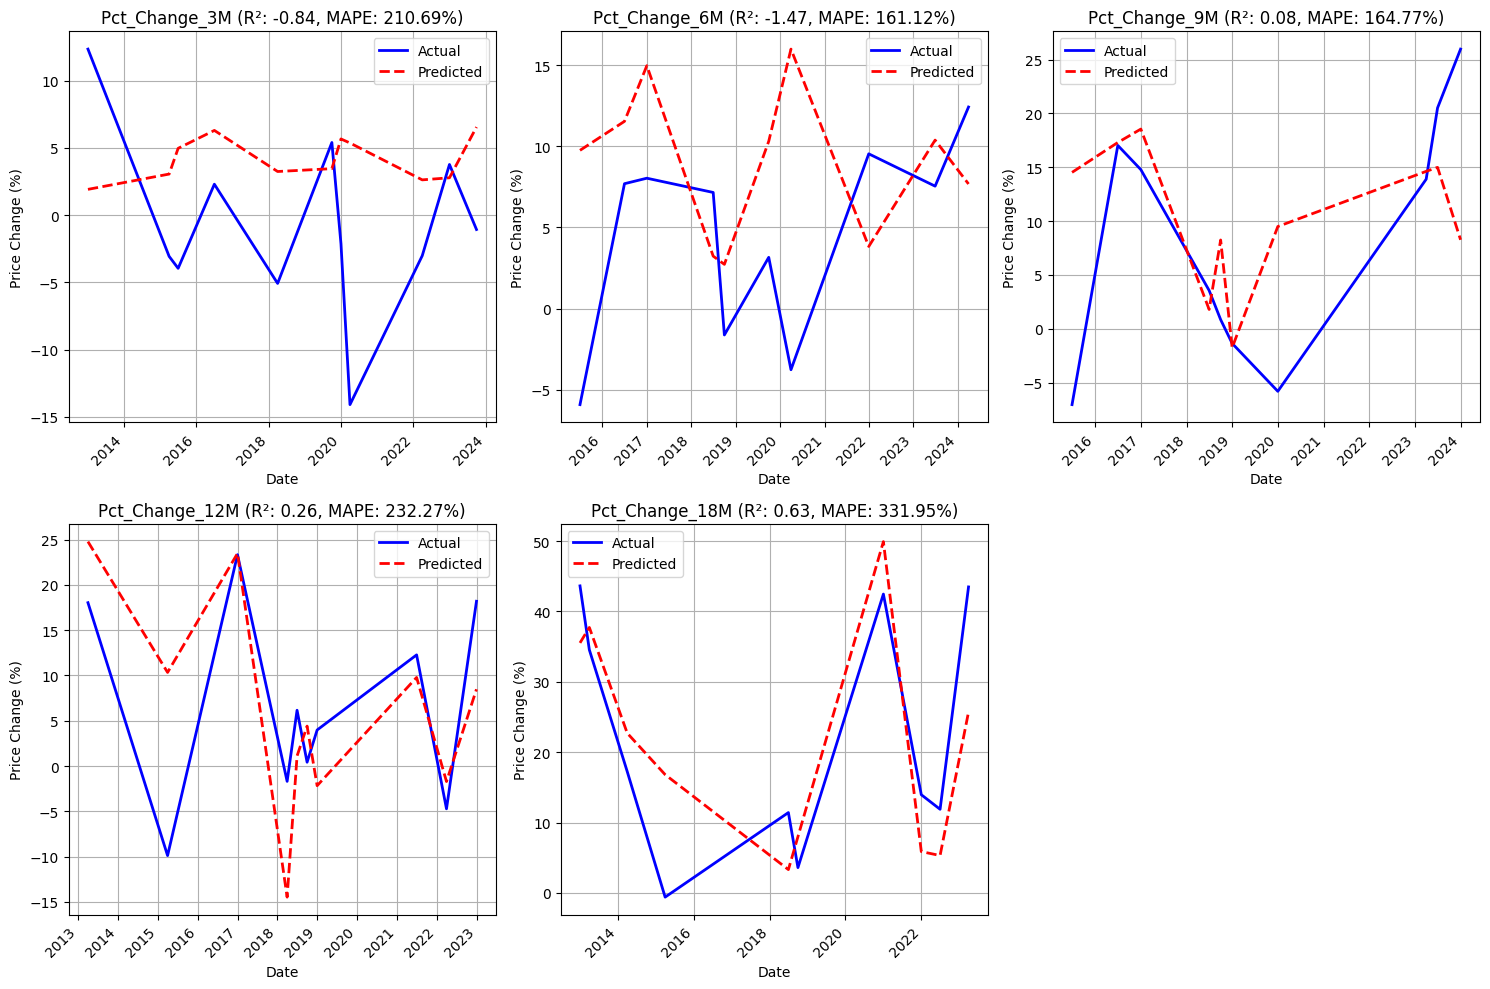

In [203]:
plot_actual_vs_predicted(results_pct, quarterly_df, ylabel='Price Change (%)', filename='images/actual_vs_predicted_pct_change.png')


## BRK_Close as Targets

In [204]:
print(f"{len(abs_feature_list)} features used: {abs_feature_list}")
results_abs = train_linear_models_test_split(abs_target_list, abs_feature_list, quarterly_df, scale_features=True, test_size=0.2, random_state=42)


6 features used: ['Pe-ratio', 'SP500_PE', 'Price-book', 'SP500_Performance_Gap', 'BRK_Close_lag1', 'Cash_Equivalents_to_Assets_Ratio']

Training model for BRK_Close_3M:
Coefficients: {'Pe-ratio': np.float64(-3.1918052325921398), 'SP500_PE': np.float64(3.059536762215343), 'Price-book': np.float64(3.7838725788420042), 'SP500_Performance_Gap': np.float64(9.187629831794084), 'BRK_Close_lag1': np.float64(92.49734009173649), 'Cash_Equivalents_to_Assets_Ratio': np.float64(-2.1951017769731647)}
Intercept: 200.99348717225482
R²: 0.97
MSE: 388.26
RMSE: 19.70
MAE: 16.98
MAPE: 11.47%
Average of actuals: 191.60
Average of predicteds: 197.24
Standard Deviation of the absolute errors (w.r.t mae): 10.45
Min of absoluate errors: 6.68
Max of absoluate errors: 42.02
Standard Deviation of percent absolute errors (w.r.t mape): 8.26%
Min of percent absolute errors: 1.55%
Max of percent absolute errors: 30.33%

Training model for BRK_Close_6M:
Coefficients: {'Pe-ratio': np.float64(-3.882661829851307), 'SP500

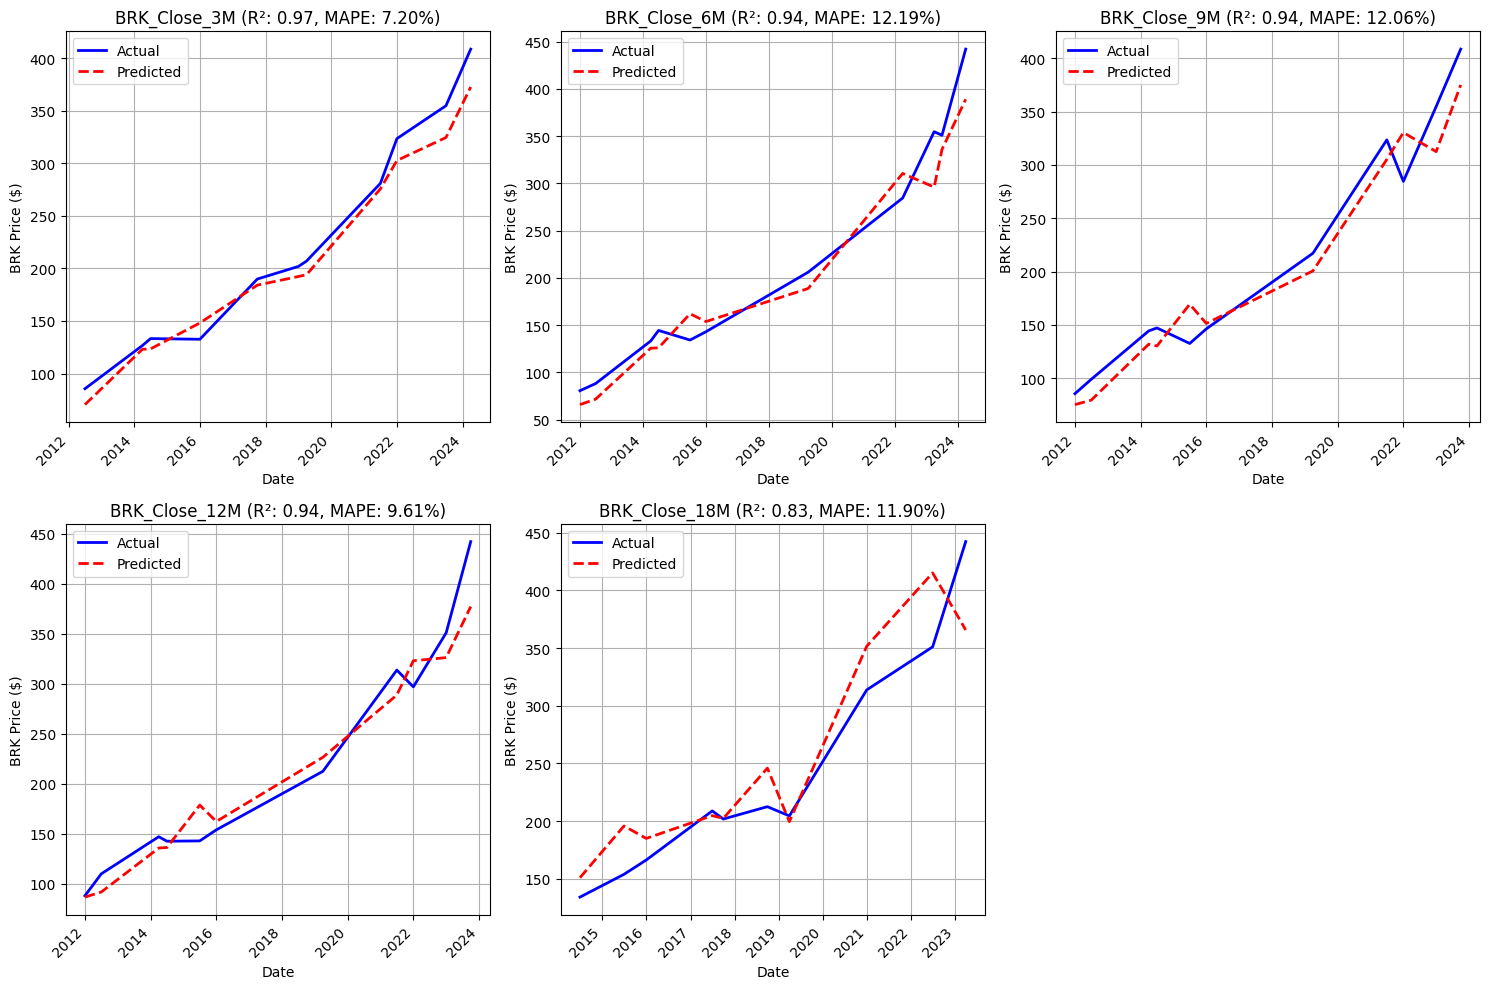

In [156]:
plot_actual_vs_predicted(results_abs, quarterly_df, ylabel='BRK Price ($)', filename='images/actual_vs_predicted_prices.png')


### Legacy Code
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

models = {}

for target in targets:
    df = quarterly_df.dropna(subset=[target] + features)
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    models[target] = model
    print(f"\n{target}:")
    print("Coefficients:", dict(zip(features, model.coef_)))
    print("Intercept:", model.intercept_)
    print("Test R²:", r2_score(y_test, y_pred))
    print("Test MSE:", mean_squared_error(y_test, y_pred))

In [63]:
print(quarterly_df.tail())

         Date   BRK_Close   SP500_Close   DJIA_Close  Pe-ratio  Price-book  Cash_Equivalents_to_Assets_Ratio  SP500_PE  BRK_Close_3M  BRK_Close_6M  BRK_Close_9M  BRK_Close_12M  BRK_Close_18M  SP500_Return  SP500_Performance_Gap
55 2023-12-31  350.994126  34933.046689  4464.907622      9.96        0.86                              0.15     24.01    393.337377    408.615715    442.181719     461.731719            NaN      0.075184              -0.064816
56 2024-03-31  393.337377  38517.439485  4992.540984      8.06        0.82                              0.15     24.01    408.615715    442.181719    461.731719            NaN            NaN      0.159512               0.019512
57 2024-06-30  408.615715  38807.051649  5246.626519     12.41        0.95                              0.25     24.01    442.181719    461.731719           NaN            NaN            NaN      0.153494               0.013494
58 2024-09-30  442.181719  40602.316711  5543.469223      9.30        0.97              

### 2. How Do the Train-Test Split Results Compare to Those Without Train-Test Split?

**Short Answer**: The train-test split results show slightly lower R² and higher MSE compared to the full dataset (without split), which is expected due to evaluating on unseen test data. The models remain robust, particularly for 3M and 6M (test R²: 0.9724, 0.9164), but the 9M and 18M models show larger drops, indicating potential overfitting or data limitations for longer horizons.

#### Comparison of R² and MSE
Here’s a comparison of the full dataset (training on all data) vs. train-test split (80% train, 20% test, random_state=42):

| Model            | Full R² | Full MSE | Test R² | Test MSE | R² Change | MSE Change |
|------------------|---------|----------|---------|----------|-----------|------------|
| BRK_Close_3M     | 0.9754  | 238.97   | 0.9724  | 279.32   | -0.0030   | +40.35     |
| BRK_Close_6M     | 0.9506  | 473.31   | 0.9164  | 1156.41  | -0.0342   | +683.10    |
| BRK_Close_9M     | 0.9242  | 714.43   | 0.8702  | 1473.63  | -0.0540   | +759.20    |
| BRK_Close_12M    | 0.9087  | 846.28   | 0.9011  | 1189.32  | -0.0076   | +343.04    |
| BRK_Close_18M    | 0.9303  | 622.46   | 0.8507  | 1300.12  | -0.0796   | +677.66    |

**Observations**:
- **R²**:
  - Test R² is lower than full R² for all models, as expected, since test data is unseen, revealing overfitting in the full dataset fit.
  - 3M and 12M show small drops (0.0030, 0.0076), indicating robust generalization.
  - 6M, 9M, and 18M show larger drops (0.0342, 0.0540, 0.0796), suggesting greater overfitting, especially for longer horizons.
  - All test R² values remain high (>0.85), with 3M (0.9724) and 6M (0.9164) particularly strong, suitable for option pricing.
- **MSE**:
  - Test MSE is higher than full MSE, reflecting larger errors on unseen data.
  - 3M has a small increase (238.97 → 279.32, RMSE: 15.46 → 16.71), indicating good generalization.
  - 6M, 9M, and 18M show significant increases (e.g., 9M: 714.43 → 1473.63, RMSE: 26.73 → 38.39), suggesting reduced accuracy on test data.
  - 12M’s moderate increase (846.28 → 1189.32, RMSE: 29.09 → 34.49) aligns with its stable R².
- **Context**: BRK-B prices range from ~$50 (2010) to ~$500 (2024). Test RMSE values (16.71–38.39) are ~3–8% of the price range, acceptable but less precise for longer horizons.

#### Why the Differences?
1. **Overfitting in Full Dataset**:
   - Full dataset R² and MSE are computed on the **training data**, where the model can overfit by memorizing patterns, inflating R² and underestimating MSE.
   - Train-test split evaluates on **unseen test data** (20% of ~59 quarters ≈ 12 quarters), revealing the model’s true generalization ability.
   - Larger R² drops (e.g., 18M: -0.0796) indicate overfitting, especially for 9M and 18M, where fewer data points (~54–56 quarters) and complex features (e.g., `SP500_Performance_Gap`) increase variance.
2. **Data Limitations**:
   - The small dataset (~59 quarters) limits the test set size (~12 quarters), making test metrics sensitive to the random split (random_state=42).
   - Longer horizons (9M, 12M, 18M) have fewer valid target rows due to shifting (`shift(-3)`, etc.), reducing training data and increasing test variability.
3. **Feature Stability**:
   - Coefficients differ between full and test models, e.g.:
     - 3M: `Price-book` (142.19 → 127.32), `Cash_Equivalents_to_Assets_Ratio` (115.49 → 158.06).
     - 18M: `Cash_Equivalents_to_Assets_Ratio` remains negative (-519.40 → -550.25), suggesting a persistent issue.
   - These changes reflect sensitivity to the train-test split, indicating potential multicollinearity or feature instability.

#### Persistent Issue: Negative `Cash_Equivalents_to_Assets_Ratio`
- Despite removing 2025 data, `Cash_Equivalents_to_Assets_Ratio` is negative in 9M (-176.26), 12M (-308.57), and 18M (-519.40) for full models, and 12M (-111.08) and 18M (-550.25) for test models.
- **Why?**:
  - **Multicollinearity**: High correlation between features (e.g., `SP500_Close`, `DJIA_Close`, `SP500_PE`) may distort coefficients. The negative coefficient is counterintuitive, as higher liquidity should support BRK-B’s price.
  - **Data Scale**: `Cash_Equivalents_to_Assets_Ratio` (0–1) has a smaller range than `BRK_Close` ($50–$500), so large negative coefficients may compensate for other features.
  - **Outliers**: Extreme values in `quarterly_df` (e.g., low liquidity periods) could skew the relationship.
- **Action**: Investigate multicollinearity and outliers (see recommendations).

#### Model Robustness
- **3M and 6M**: Test R² (0.9724, 0.9164) and RMSE (16.71, 34.01) indicate strong generalization, making these models reliable for short-term option pricing.
- **9M and 18M**: Larger R² drops (0.0540, 0.0796) and high test MSE (1473.63, 1300.12) suggest overfitting or insufficient data for long-term predictions.
- **12M**: Moderate drop (0.0076) and MSE increase (1189.32) indicate reasonable generalization but less reliability than 3M/6M.

**Conclusion**:
- The train-test split results confirm that 3M and 6M models are robust (high test R², moderate MSE increase), ideal for call option strategies.
- 9M, 12M, and 18M show larger performance drops, indicating overfitting and challenges with long-term predictions.
- The negative `Cash_Equivalents_to_Assets_Ratio` in 9M–18M suggests multicollinearity or data issues, requiring further investigation.
- The full dataset results overestimate performance due to overfitting, making the train-test split a more realistic assessment for real-world predictions.

## Implementing Regularization

### Ridge with StandardScaler



In [244]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def train_ridge_models(target_list, feature_list, data, test_size=0.2, random_state=42, alpha_range=[0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]):
    """
    Train Ridge regression models for multiple targets with specified features.
    
    Parameters:
    - target_list (list): List of target variables (e.g., ['Pct_Change_3M', 'Pct_Change_6M'] or ['BRK_Close_3M', 'BRK_Close_6M']).
    - feature_list (list): List of feature variables (e.g., ['Pe-ratio', 'SP500_PE']).
    - data (pd.DataFrame): DataFrame containing the data.
    - test_size (float): Proportion of data for testing (default: 0.2).
    - random_state (int): Seed for reproducibility (default: 42).
    - alpha_range (list): List of alpha values for GridSearchCV (default: [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]).
    
    Returns:
    - dict: Results for each target, including model, metrics, and predictions.
    """
    results = {}
    scaler = StandardScaler()
    
    for target in target_list:
        print(f"\nTraining model for {target}:")
        # Drop rows with NaN in target or features
        df = data.dropna(subset=[target] + feature_list)
        X = df[feature_list]
        y = df[target]
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        # Scale features
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Hyperparameter tuning with GridSearchCV
        param_grid = {'alpha': alpha_range}
        grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
        grid.fit(X_train_scaled, y_train)
        best_alpha = grid.best_params_['alpha']
        
        # Train Ridge model with best alpha
        model = Ridge(alpha=best_alpha)
        model.fit(X_train_scaled, y_train)
        
        # Predict and evaluate
        y_pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + 1e-6))) * 100
        # mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100 if not np.any(y_test == 0) else np.nan  # Avoid division by zero

        # Calculate variance of error
        abs_errors = np.abs(y_test - y_pred)
        abs_pst_errors = np.abs((y_test - y_pred) / y_test) * 100

        
        # Store results
        results[target] = {
            'model': model,
            'coefficients': dict(zip(feature_list, model.coef_)),
            'intercept': model.intercept_,
            'R²': r2,
            'MSE': mse,
            'MAE': mae,
            'MAPE': mape,
            'y_actual': y_test,  # pandas Series with test set index
            'y_pred': pd.Series(y_pred, index=y_test.index)  # Align indices with y_test
        }

         
        
        
        print(f"\n{target} (Ridge):")
        print("Best alpha used:", grid.best_params_)
        print("Coefficients:", dict(zip(feature_list, model.coef_)))
        print("Intercept:", model.intercept_)
    
        # Print results
        print(f"Best alpha used: {best_alpha}")
        print(f"Test R²: {r2:.2f}")
        print(f"Test MSE: {mse:.2f}")
        print(f"Test MAE: {mae:.2f}")
        print(f"Test MAPE: {mape:.2f}%")
        print(f"Average of actuals: {y_test.mean():.2f}")
        print(f"Average of predicteds: {y_pred.mean():.2f}")
        print(f"Standard Deviation of the absolute errors (w.r.t mae): {abs_errors.std(ddof=1):.2f}")
        print(f"Min of absoluate errors: {abs_errors.min():.2f}")
        print(f"Max of absoluate errors: {abs_errors.max():.2f}")
        print(f"Standard Deviation of percent absolute errors (w.r.t mape): {abs_pst_errors.std(ddof=1):.2f}%")
        print(f"Min of percent absolute errors: {abs_pst_errors.min():.2f}%")
        print(f"Max of percent absolute errors: {abs_pst_errors.max():.2f}%")
    
    return results

### Absolute Prices as Targets

In [245]:
print(f"{len(abs_feature_list)} features used: {abs_feature_list}")
results_abs = train_ridge_models(abs_target_list, abs_feature_list, quarterly_df, test_size=0.3)

6 features used: ['Pe-ratio', 'SP500_PE', 'Price-book', 'SP500_Performance_Gap', 'BRK_Close_lag1', 'Cash_Equivalents_to_Assets_Ratio']

Training model for BRK_Close_3M:

BRK_Close_3M (Ridge):
Best alpha used: {'alpha': 0.5}
Coefficients: {'Pe-ratio': np.float64(-3.836434737369588), 'SP500_PE': np.float64(3.9701801666828667), 'Price-book': np.float64(10.30200968774515), 'SP500_Performance_Gap': np.float64(9.514655344779484), 'BRK_Close_lag1': np.float64(85.77984282730505), 'Cash_Equivalents_to_Assets_Ratio': np.float64(-2.202904653908528)}
Intercept: 210.40488953372878
Best alpha used: 0.5
Test R²: 0.96
Test MSE: 366.29
Test MAE: 16.49
Test MAPE: 12.60%
Average of actuals: 174.34
Average of predicteds: 176.47
Standard Deviation of the absolute errors (w.r.t mae): 10.00
Min of absoluate errors: 4.81
Max of absoluate errors: 33.75
Standard Deviation of percent absolute errors (w.r.t mape): 10.34%
Min of percent absolute errors: 1.09%
Max of percent absolute errors: 42.52%

Training model 

## Precent Changes as Targets

## Legacy Code -Do Not Use

# Calculate percentage change targets
for months in [3, 6, 9, 12, 18]:
    # Calculate the number of quarters ahead (assuming 3 months per quarter)
    quarters_ahead = months // 3
    # Calculate percentage change: (future price - current price) / current price * 100
    quarterly_df[f'Pct_Change_{months}M'] = (
        (quarterly_df['BRK_Close'].shift(-quarters_ahead) - quarterly_df['BRK_Close']) / quarterly_df['BRK_Close'] * 100
    )

# Add BRK_Close_lag1 change percent as a feature
quarterly_df['BRK_Close_lag1_pct'] = (quarterly_df['BRK_Close'] - quarterly_df['BRK_Close'].shift(1)) / quarterly_df['BRK_Close'].shift(1) * 100
features.append('BRK_Close_lag1_pct')
                
# Add SP500_Close percent as a feature
quarterly_df['SP500_Close_lag1_pct'] = (quarterly_df['SP500_Close'] - quarterly_df['SP500_Close'].shift(1)) / quarterly_df['SP500_Close'].shift(1) * 100
features.append('SP500_Close_lag1_pct')

# Save the updated DataFrame
quarterly_df.to_csv('brk_model_data_with_pct_change.csv', index=False)
print("Percentage change targets added and saved to brk_model_data_with_pct_change.csv")

In [256]:
print(f"{len(pct_feature_list)} features used: {pct_feature_list}")
results_pct = train_ridge_models(pct_target_list, pct_feature_list, quarterly_df, test_size=0.3)


9 features used: ['Pe-ratio', 'SP500_PE', 'Price-book', 'SP500_Performance_Gap', 'SP500_Performance_Lag2_Gap', 'SP500_Performance_Lag4_Gap', 'SP500_Performance_Lag6_Gap', 'BRK_Close_lag1_pct', 'BRK_Close_lag2_pct']

Training model for Pct_Change_3M:

Pct_Change_3M (Ridge):
Best alpha used: {'alpha': 100.0}
Coefficients: {'Pe-ratio': np.float64(-0.3299997557871557), 'SP500_PE': np.float64(0.4718874495366736), 'Price-book': np.float64(-0.02725929627373789), 'SP500_Performance_Gap': np.float64(0.24683288429977365), 'SP500_Performance_Lag2_Gap': np.float64(-0.218789121356236), 'SP500_Performance_Lag4_Gap': np.float64(-0.08537312700760157), 'SP500_Performance_Lag6_Gap': np.float64(-0.4668914192750008), 'BRK_Close_lag1_pct': np.float64(0.03057974906177467), 'BRK_Close_lag2_pct': np.float64(-0.11745202404186951)}
Intercept: 4.460025751809958
Best alpha used: 100.0
Test R²: -0.10
Test MSE: 55.67
Test MAE: 6.27
Test MAPE: 238.44%
Average of actuals: 1.96
Average of predicteds: 4.45
Standard Dev

### Non-function call for Ridge Model (Legacy)

In [18]:

from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Assuming quarterly_df is prepared (from your pipeline)
# Linear regression with Ridge/Lasso and train-test split
# targets = ['BRK_Close_3M', 'BRK_Close_6M', 'BRK_Close_9M', 'BRK_Close_12M', 'BRK_Close_18M']
# features = ['SP500_Close', 'DJIA_Close', 'Pe-ratio', 'Price-book', 'Cash_Equivalents_to_Assets_Ratio', 'SP500_PE', 'SP500_Performance_Gap']

models = {}
results = {}
scaler = StandardScaler()

for target in targets:
    df = quarterly_df.dropna(subset=[target] + features)
    X = df[features]
    y = df[target]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # print(X_test.head())
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Cross validation to find best alpha
    param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}  # Previously used [0.1, 1.0, 10.0]
    grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
    grid.fit(X_train_scaled, y_train)
    # print("Best alpha:", grid.best_params_)
    alpha_used = float(grid.best_params_['alpha'])
    
    # Fit Ridge model (or replace with Lasso(alpha=1.0))
    model = Ridge(alpha=alpha_used)
    model.fit(X_train_scaled, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)


    # Predict and evaluate
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    avg_brk_price = y_test.mean()

    
    models[target] = model
    results[target] = {
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'MAE_%': mae / avg_brk_price * 100,
        'Alpha': alpha_used
    }
    
    print(f"\n{target} (Ridge):")
    print("Best alpha used:", grid.best_params_)
    print("Coefficients:", dict(zip(features, model.coef_)))
    print("Intercept:", model.intercept_)

    print(f"Test R²: {r2:.2f}")
    print(f"Test MSE: {mse:.2f}")
    print(f"Test MAE: {mae:.2f} ({mae/avg_brk_price*100:.1f}% of average BRK price)")
    


BRK_Close_3M (Ridge):
Best alpha used: {'alpha': 1.0}
Coefficients: {'Pe-ratio': np.float64(-3.0703671445882743), 'SP500_PE': np.float64(6.010217214914622), 'SP500_Performance_Gap': np.float64(3.555193152316478), 'BRK_Close_lag1': np.float64(88.07963640270901), 'Cash_Equivalents_to_Assets_Ratio': np.float64(4.980630300397482)}
Intercept: 198.52500532237045
Test R²: 0.96
Test MSE: 389.57
Test MAE: 16.43 (7.4% of average BRK price)

BRK_Close_6M (Ridge):
Best alpha used: {'alpha': 1.0}
Coefficients: {'Pe-ratio': np.float64(-5.324009044215941), 'SP500_PE': np.float64(10.152606911684746), 'SP500_Performance_Gap': np.float64(4.733269528443816), 'BRK_Close_lag1': np.float64(81.35144364128165), 'Cash_Equivalents_to_Assets_Ratio': np.float64(2.8700552128446932)}
Intercept: 203.2167625991014
Test R²: 0.93
Test MSE: 956.25
Test MAE: 25.29 (11.8% of average BRK price)

BRK_Close_9M (Ridge):
Best alpha used: {'alpha': 1.0}
Coefficients: {'Pe-ratio': np.float64(-2.6754122105727385), 'SP500_PE': np

### Ridge Regularization
- Applied Ridge regression with cross-validated `alpha` (0.1–10.0) and `StandardScaler`.
- Improved 9M (R²: 0.8931 vs. 0.8702) and stabilized coefficients, but 6M, 12M, 18M need further tuning due to multicollinearity.

## Feature Correlation Matric

In [20]:
!pip install seaborn


Feature Correlations:
                                  Pe-ratio  SP500_PE  SP500_Performance_Gap  \
Pe-ratio                          1.000000 -0.119514              -0.267650   
SP500_PE                         -0.119514  1.000000               0.057561   
SP500_Performance_Gap            -0.267650  0.057561               1.000000   
BRK_Close_lag1                    0.025307  0.575797               0.019255   
Cash_Equivalents_to_Assets_Ratio  0.009346  0.656952               0.167533   

                                  BRK_Close_lag1  \
Pe-ratio                                0.025307   
SP500_PE                                0.575797   
SP500_Performance_Gap                   0.019255   
BRK_Close_lag1                          1.000000   
Cash_Equivalents_to_Assets_Ratio        0.722365   

                                  Cash_Equivalents_to_Assets_Ratio  
Pe-ratio                                                  0.009346  
SP500_PE                                           

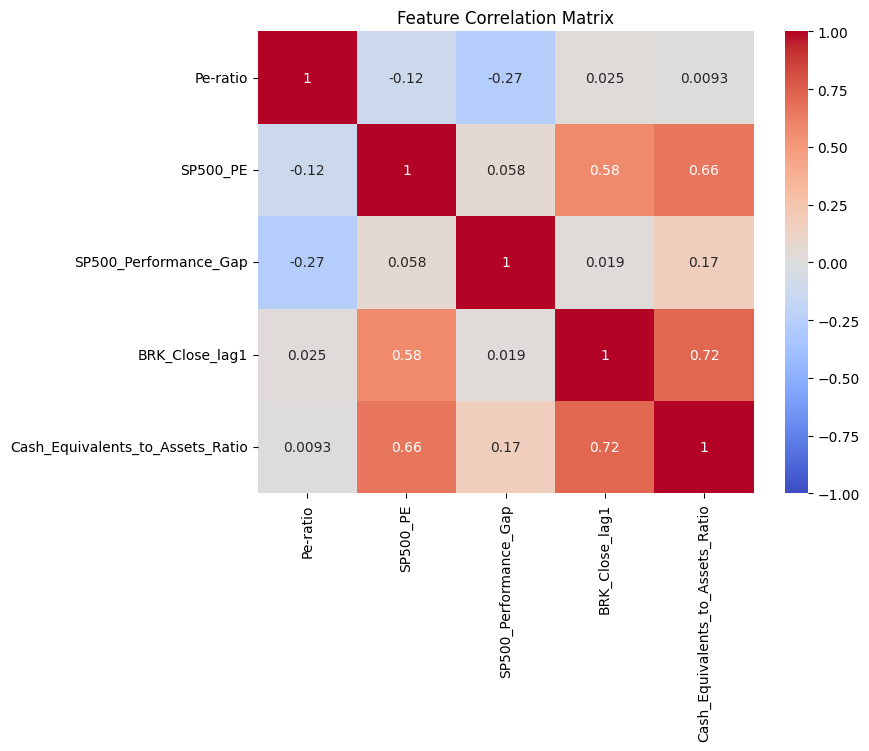

In [23]:
import matplotlib.pyplot as plt

# Check feature correlations
print("\nFeature Correlations:")
correlation_matrix = quarterly_df[features].corr()
print(correlation_matrix)

# Visualize correlations
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.savefig('images/feature_correlations.png')
plt.show()

## Visualization Code: Predicted vs. Actual for Each Horizon



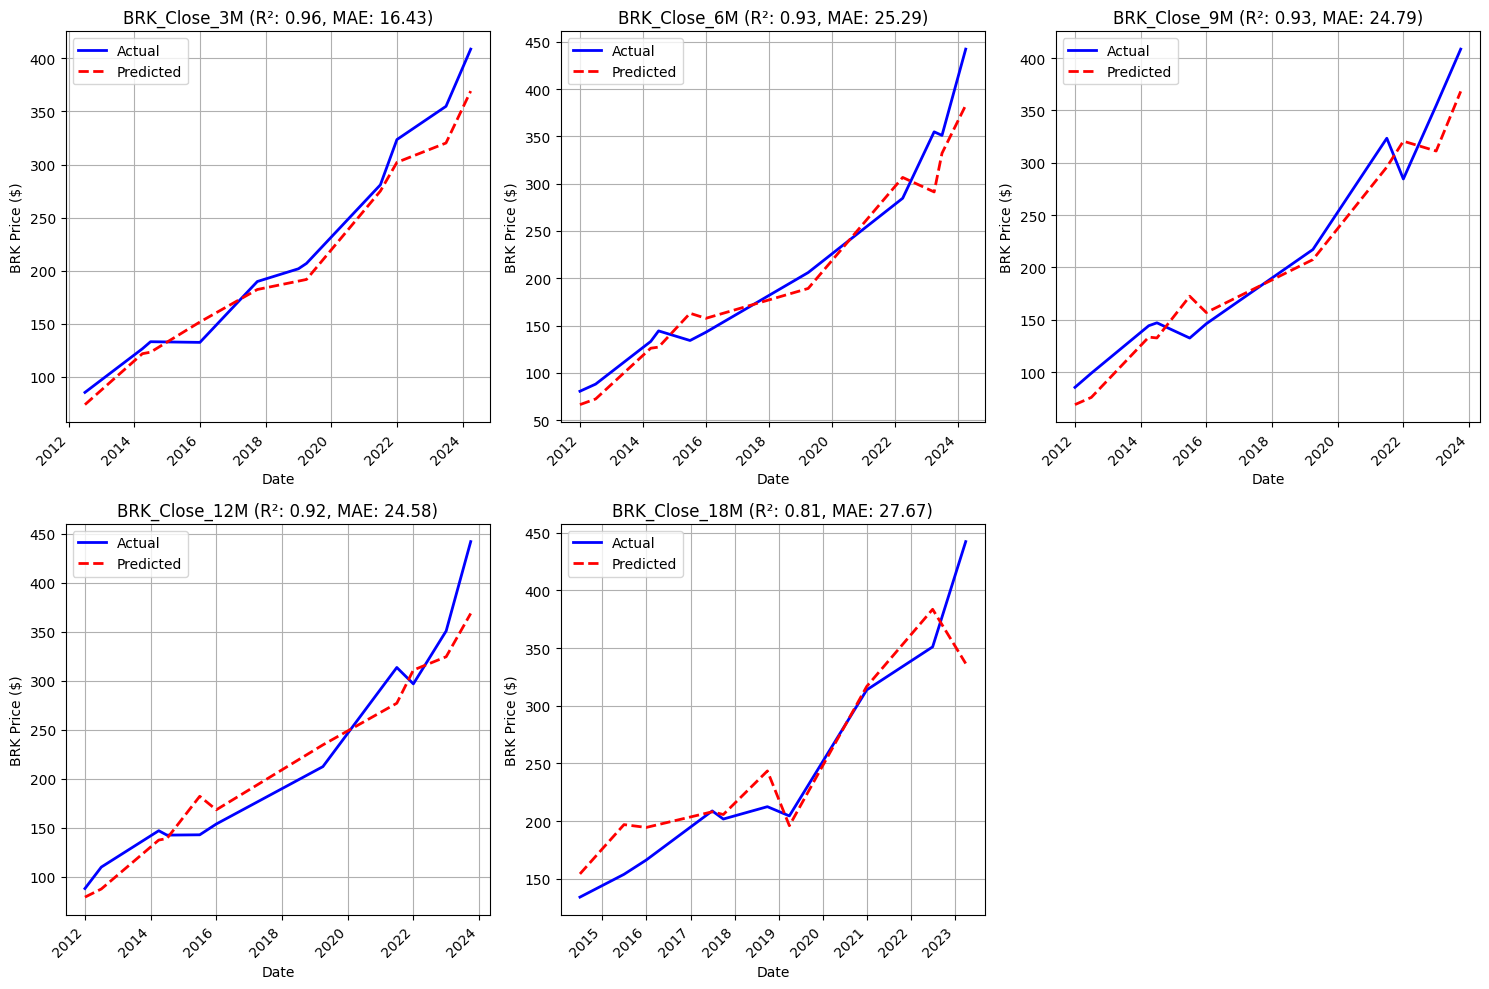

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

# Define features and targets
targets = ['BRK_Close_3M', 'BRK_Close_6M', 'BRK_Close_9M', 'BRK_Close_12M', 'BRK_Close_18M']
features = ['Pe-ratio', 'SP500_PE', 'SP500_Performance_Gap', 'BRK_Close_lag1', 'Cash_Equivalents_to_Assets_Ratio']
scaler = StandardScaler()

# Create a 2x3 grid for plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  # Flatten for easy iteration

for idx, target in enumerate(targets):
    # Clean data and include Date for plotting
    df = quarterly_df.dropna(subset=[target] + features + ['Date'])
    X = df[features]
    y = df[target]
    dates = df['Date']
    
    # Train-test split (maintain index alignment)
    X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
        X, y, dates, test_size=0.2, random_state=42
    )
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Ridge model (alpha=1.0 from your results)
    model = Ridge(alpha=1.0)
    model.fit(X_train_scaled, y_train)
    
    # Predict and convert y_pred to Series with test set indices
    y_pred = model.predict(X_test_scaled)
    y_pred_series = pd.Series(y_pred, index=y_test.index)
    
    # Sort by date for smooth line plots
    sorted_indices = dates_test.sort_values().index
    dates_test_sorted = dates_test.loc[sorted_indices]
    y_test_sorted = y_test.loc[sorted_indices]
    y_pred_sorted = y_pred_series.loc[sorted_indices]
    
    # Plot actual and predicted prices vs. time
    axes[idx].plot(dates_test_sorted, y_test_sorted, label='Actual', color='blue', linewidth=2)
    axes[idx].plot(dates_test_sorted, y_pred_sorted, label='Predicted', color='red', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('BRK Price ($)')
    axes[idx].set_title(f'{target} (R²: {r2_score(y_test, y_pred):.2f}, MAE: {mean_absolute_error(y_test, y_pred):.2f})')
    axes[idx].legend()
    axes[idx].grid(True)
    # Rotate x-axis labels for readability
    plt.setp(axes[idx].get_xticklabels(), rotation=45, ha='right')

# Remove empty subplot (last cell)
fig.delaxes(axes[-1])

# Adjust layout and save
plt.tight_layout()
plt.savefig('images/prices_vs_time_all.png')
plt.show()

## Special Improvement for BRK_Close_18M

In [17]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Add gap to intrinsic value to quarterly_df
quarterly_df['Intrinsic_Value'] = quarterly_df['BRK_Close'] / quarterly_df['Price-book']
quarterly_df['Gap_Intrinsic'] = (quarterly_df['BRK_Close'] - quarterly_df['Intrinsic_Value']) / quarterly_df['Intrinsic_Value']

# Update features to include Gap_Intrinsic
features_18M = ['Pe-ratio', 'SP500_PE', 'SP500_Performance_Gap', 'BRK_Close_lag1', 'Cash_Equivalents_to_Assets_Ratio', 'Gap_Intrinsic']
target = 'BRK_Close_18M'  # Focus on 18M to improve performance

# Clean data for specific target
df = quarterly_df.dropna(subset=[target] + features_18M)
X = df[features_18M]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GridSearchCV for alpha
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}
grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
grid.fit(X_train_scaled, y_train)
alpha_used = float(grid.best_params_['alpha'])

# Train Ridge model
model = Ridge(alpha=alpha_used)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
avg_brk_price = y_test.mean()

# Print results
print(f"\n{target} (Ridge with Gap_Intrinsic):")
print("Best alpha used:", grid.best_params_)
print("Coefficients:", dict(zip(features_18M, model.coef_)))
print("Intercept:", model.intercept_)
print(f"Test R²: {r2:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f} ({mae/avg_brk_price*100:.1f}% of average BRK price)")

# Save updated quarterly_df with new feature
quarterly_df.to_csv('brk_model_data_with_intrinsic.csv', index=False)
print("Updated quarterly_df saved to brk_model_data_with_intrinsic.csv")


BRK_Close_18M (Ridge with Gap_Intrinsic):
Best alpha used: {'alpha': 1.0}
Coefficients: {'Pe-ratio': np.float64(-9.052399983682934), 'SP500_PE': np.float64(20.635099652472782), 'SP500_Performance_Gap': np.float64(-11.690689669504414), 'BRK_Close_lag1': np.float64(86.17673943293252), 'Cash_Equivalents_to_Assets_Ratio': np.float64(-8.62923970881669), 'Gap_Intrinsic': np.float64(-10.501115550735422)}
Intercept: 210.07586031664877
Test R²: 0.82
Test MSE: 1524.24
Test MAE: 28.96 (12.1% of average BRK price)
Updated quarterly_df saved to brk_model_data_with_intrinsic.csv


In [30]:
# Debugging
print(quarterly_df['BRK_Close'].describe())

count     60.000000
mean     192.943456
std      101.161053
min       72.209687
25%      115.566016
50%      172.014169
75%      251.991142
max      461.731719
Name: BRK_Close, dtype: float64


## Lasso Regularization

In [15]:
models = {}
scaler = StandardScaler()

for target in targets:
    df = quarterly_df.dropna(subset=[target] + features)
    X = df[features]
    y = df[target]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # print(X_test.head())
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Lasso()
    
    # Cross validation to find best alpha
    param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
    grid = GridSearchCV(model, param_grid, cv=5, scoring='r2')
    grid.fit(X_train_scaled, y_train)

    # Predict on test set
    y_pred =  grid.predict(X_test_scaled)


    # To find MAE
    mae = mean_absolute_error(y_test, y_pred)
    avg_brk_price = y_test.mean()
    
    print(f"\n{target} (Lasso):")
    print("Best alpha:", grid.best_params_)
    print("Coefficients:", dict(zip(features, grid.best_estimator_.coef_)))
    print("Intercept:", grid.best_estimator_.intercept_)
    print("Test R²:", r2_score(y_test, y_pred))
    print("Test MSE:", mean_squared_error(y_test, y_pred))
    print(f"Test MAE: {mae:.2f} ({mae/avg_brk_price*100:.1f}% of average BRK price)")
    
    models[target] = model
 


BRK_Close_3M (Lasso):
Best alpha: {'alpha': 5.0}
Coefficients: {'Pe-ratio': np.float64(-0.0), 'SP500_PE': np.float64(2.5021123384626796), 'SP500_Performance_Gap': np.float64(0.0), 'BRK_Close_lag1': np.float64(87.03254240134162), 'Cash_Equivalents_to_Assets_Ratio': np.float64(3.4534690963637678)}
Intercept: 198.52500532237045
Test R²: 0.9444773798721032
Test MSE: 562.7752218309523
Test MAE: 19.03 (8.6% of average BRK price)

BRK_Close_6M (Lasso):
Best alpha: {'alpha': 5.0}
Coefficients: {'Pe-ratio': np.float64(-1.322850968100606), 'SP500_PE': np.float64(7.8973804312117135), 'SP500_Performance_Gap': np.float64(0.3782474917954518), 'BRK_Close_lag1': np.float64(80.67187445394057), 'Cash_Equivalents_to_Assets_Ratio': np.float64(0.0)}
Intercept: 203.21676259910143
Test R²: 0.9421695321436301
Test MSE: 799.7447143652247
Test MAE: 21.17 (9.9% of average BRK price)

BRK_Close_9M (Lasso):
Best alpha: {'alpha': 5.0}
Coefficients: {'Pe-ratio': np.float64(-0.0), 'SP500_PE': np.float64(10.454551758

## Elastic Net

In [57]:

from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Assuming quarterly_df is prepared (from your pipeline)
# Linear regression with Ridge/Lasso and train-test split
# targets = ['BRK_Close_3M', 'BRK_Close_6M', 'BRK_Close_9M', 'BRK_Close_12M', 'BRK_Close_18M']
# features = ['SP500_Close', 'DJIA_Close', 'Pe-ratio', 'Price-book', 'Cash_Equivalents_to_Assets_Ratio', 'SP500_PE', 'SP500_Performance_Gap']

models = {}
scaler = StandardScaler()

for target in targets:
    df = quarterly_df.dropna(subset=[target] + features)
    X = df[features]
    y = df[target]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # print(X_test.head())
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Setup ElasticNet
    model = ElasticNet()
    param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0], 'l1_ratio': [0.1, 0.5, 0.9]}
    # param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0], 'l1_ratio': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
    grid = GridSearchCV(model, param_grid, cv=5, scoring='r2')

    grid.fit(X_train_scaled, y_train)
    
    # Predict on test set
    y_pred = grid.predict(X_test_scaled)

    # To find MAE
    mae = mean_absolute_error(y_test, y_pred)
    avg_brk_price = y_test.mean()
    
    
    models[target] = grid.best_estimator_
    print(f"\n{target} (Elastic Net):")
    print("Best params:", grid.best_params_)
    print("Coefficients:", dict(zip(features, grid.best_estimator_.coef_)))
    print("Intercept:", grid.best_estimator_.intercept_)
    print("Test R²:", r2_score(y_test, y_pred))
    print("Test MSE:", mean_squared_error(y_test, y_pred))
    print(f"Test MAE: {mae:.2f} ({mae/avg_brk_price*100:.1f}% of average BRK price)")
    
    # Price percentage change w.r.t current price
    # price_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # percentage_rmse = (price_rmse / y_test.mean()) * 100
    # print(f"Percentage RMSE: {percentage_rmse:.2f}%")



BRK_Close_3M (Elastic Net):
Best params: {'alpha': 0.5, 'l1_ratio': 0.9}
Coefficients: {'Pe-ratio': np.float64(-2.371964407978427), 'SP500_PE': np.float64(6.121878746603818), 'SP500_Performance_Gap': np.float64(2.3581398634279203), 'BRK_Close_lag1': np.float64(83.67661986639511), 'Cash_Equivalents_to_Assets_Ratio': np.float64(7.2450519736823535)}
Intercept: 198.52500532237045
Test R²: 0.9489164954686276
Test MSE: 517.7805105076651
Percentage RMSE: 10.24%

BRK_Close_6M (Elastic Net):
Best params: {'alpha': 0.5, 'l1_ratio': 0.9}
Coefficients: {'Pe-ratio': np.float64(-5.019321138714433), 'SP500_PE': np.float64(10.019882900238462), 'SP500_Performance_Gap': np.float64(3.8337150190097184), 'BRK_Close_lag1': np.float64(77.83972246954767), 'Cash_Equivalents_to_Assets_Ratio': np.float64(4.537082952251363)}
Intercept: 203.2167625991014
Test R²: 0.9233667840722446
Test MSE: 1059.770250091115
Percentage RMSE: 15.16%

BRK_Close_9M (Elastic Net):
Best params: {'alpha': 1.0, 'l1_ratio': 0.9}
Coeffic

## Variance Inflation Factor
The VIF measures how much the variance of a feature’s regression coefficient is inflated due to correlations with other features. A high VIF indicates that a feature is highly correlated with others, causing multicollinearity, which can lead to unstable coefficients (e.g., negative Cash_Equivalents_to_Assets_Ratio) and reduced model interpretability.



In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = quarterly_df[features].dropna()
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                            Feature        VIF
0                          Pe-ratio   1.797170
1                          SP500_PE  22.127939
2             SP500_Performance_Gap   1.286968
3                    BRK_Close_lag1  10.349369
4  Cash_Equivalents_to_Assets_Ratio  30.872716


## Model Evaluation for Options ?

For call option pricing, assess whether RMSE ($15–$32) is acceptable for strike price predictions. Simulate option payoffs using predicted prices:



In [65]:
strike_price = 300
option_value = np.maximum(quarterly_df['BRK_Close_3M'] - strike_price, 0)
print(option_value)

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
6       0.000000
7       0.000000
8       0.000000
9       0.000000
10      0.000000
11      0.000000
12      0.000000
13      0.000000
14      0.000000
15      0.000000
16      0.000000
17      0.000000
18      0.000000
19      0.000000
20      0.000000
21      0.000000
22      0.000000
23      0.000000
24      0.000000
25      0.000000
26      0.000000
27      0.000000
28      0.000000
29      0.000000
30      0.000000
31      0.000000
32      0.000000
33      0.000000
34      0.000000
35      0.000000
36      0.000000
37      0.000000
38      0.000000
39      0.000000
40      0.000000
41      0.000000
42      0.000000
43      0.000000
44      0.000000
45      0.000000
46      0.000000
47     23.462904
48     13.718062
49      0.000000
50      0.000000
51      8.175968
52     26.370807
53     54.767459
54     50.994126
55     93.337377
56    108.615715
57    142.181719
58    161.7317

## Collect Financial Data fo BRK (Selenium) - Not Used
This code attempts to scrape quarterly or annual financial ratios (cash ratio, P/E ratio, price/book ratio) from MacroTrends for BRK-B using Selenium and wed-driver. requests and BeautifulSoup. 



In [16]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# Function to scrape financial ratios from MacroTrends using Selenium
def scrape_macrotrends_financials(ticker, metric, start_year=2010, end_year=2025):
    """
    Scrape financial ratios (e.g., cash ratio, P/E, price/book) from MacroTrends using Selenium.
    Args:
        ticker (str): Stock ticker (e.g., 'BRK.B').
        metric (str): Financial metric ('cash-ratio', 'pe-ratio', 'price-book').
        start_year (int): Start year for data (default: 2010).
        end_year (int): End year for data (default: 2025).
    Returns:
        pd.DataFrame: DataFrame with dates and metric values.
    """
    # Map metric to MacroTrends URL slug
    metric_urls = {
        'cash-ratio': 'balance-sheet',
        'pe-ratio': 'pe-ratio',
        'price-book': 'price-book'
    }
    
    if metric not in metric_urls:
        raise ValueError(f"Unsupported metric: {metric}. Choose from {list(metric_urls.keys())}")
    
    # Construct URL
    base_url = f"https://www.macrotrends.net/stocks/charts/{ticker}/berkshire-hathaway/{metric_urls[metric]}"
    
    try:
        # Set up Selenium with ChromeDriver
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')  # Run in headless mode (no browser window)
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
        
        # Load page
        driver.get(base_url)
        # Wait for table to load (adjust timeout as needed)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'table, div.table-responsive, div#jqxgrid'))
        )
        
        # Parse rendered HTML
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        driver.quit()
        
        # Find table (try multiple selectors)
        table = (soup.find('table', class_=re.compile('historical_data_table|table')) or
                 soup.find('div', class_='table-responsive') or
                 soup.find('div', id='jqxgrid'))
        
        if not table:
            print(f"No table found for {metric} at {base_url}. Check HTML structure.")
            return pd.DataFrame()
        
        # Extract rows (handle div-based tables)
        rows = table.find_all('tr') or table.find_all('div', class_=re.compile('row'))
        data = []
        for row in rows[1:]:  # Skip header
            cols = row.find_all(['td', 'div'])
            if len(cols) >= 2:
                date_str = cols[0].text.strip()
                value = cols[1].text.strip()
                
                # Validate date format
                if not re.match(r'\d{4}-\d{2}-\d{2}|\d{4}', date_str):
                    print(f"Skipping invalid date: {date_str}")
                    continue
                
                # Parse date
                try:
                    if '-' in date_str:
                        date = pd.to_datetime(date_str)
                    else:
                        date = pd.to_datetime(f"{date_str}-12-31")
                    if start_year <= date.year <= end_year:
                        value = value.replace('$', '').replace('%', '').replace(',', '')
                        try:
                            value = float(value)
                            data.append([date, value])
                        except ValueError:
                            print(f"Invalid value for {metric} on {date_str}: {value}")
                except ValueError:
                    print(f"Invalid date format: {date_str}")
        
        # Create DataFrame
        if data:
            col_name = 'Cash_Ratio' if metric == 'cash-ratio' else metric.capitalize()
            df = pd.DataFrame(data, columns=['Date', col_name])
            df.sort_values('Date', inplace=True)
            df.reset_index(drop=True, inplace=True)
            return df
        else:
            print(f"No valid data extracted for {metric}.")
            return pd.DataFrame()
    
    except Exception as e:
        print(f"Error fetching {metric} from {base_url}: {e}")
        return pd.DataFrame()

# Main script to collect BRK-B financials
def collect_brk_financials(ticker='BRK.B', start_year=2010, end_year=2025, output_file='brk_financials.csv'):
    """
    Collect BRK-B financial ratios (P/E, price/book, cash ratio) from MacroTrends.
    Save as CSV for merging with stock price data.
    """
    metrics = ['pe-ratio', 'price-book', 'cash-ratio']
    financial_dfs = []
    
    for metric in metrics:
        print(f"Scraping {metric} for {ticker}...")
        df = scrape_macrotrends_financials(ticker, metric, start_year, end_year)
        if not df.empty:
            financial_dfs.append(df)
        else:
            print(f"Failed to retrieve {metric}. Inspect rendered HTML or try manual collection.")
    
    if financial_dfs:
        merged_df = financial_dfs[0]
        for df in financial_dfs[1:]:
            merged_df = merged_df.merge(df, on='Date', how='outer')
        
        merged_df = merged_df[(merged_df['Date'].dt.year >= start_year) & (merged_df['Date'].dt.year <= end_year)]
        merged_df.fillna(merged_df.median(numeric_only=True), inplace=True)
        merged_df.sort_values('Date', inplace=True)
        
        merged_df.to_csv(output_file, index=False)
        print(f"Financial data saved to {output_file}")
        return merged_df
    else:
        print("No financial data retrieved. Consider manual collection.")
        return pd.DataFrame()

# Example usage in Jupyter Notebook
if __name__ == "__main__":
    ticker = 'BRK.B'
    start_year = 2010
    end_year = 2025
    output_file = 'brk_financials.csv'
    
    financial_df = collect_brk_financials(ticker, start_year, end_year, output_file)
    
    if not financial_df.empty:
        print(financial_df.head())
    else:
        print("No data to display. Inspect rendered HTML or try manual collection.")

Scraping pe-ratio for BRK.B...
Error fetching pe-ratio from https://www.macrotrends.net/stocks/charts/BRK.B/berkshire-hathaway/pe-ratio: name 're' is not defined
Failed to retrieve pe-ratio. Inspect rendered HTML or try manual collection.
Scraping price-book for BRK.B...
Error fetching price-book from https://www.macrotrends.net/stocks/charts/BRK.B/berkshire-hathaway/price-book: name 're' is not defined
Failed to retrieve price-book. Inspect rendered HTML or try manual collection.
Scraping cash-ratio for BRK.B...
Error fetching cash-ratio from https://www.macrotrends.net/stocks/charts/BRK.B/berkshire-hathaway/balance-sheet: name 're' is not defined
Failed to retrieve cash-ratio. Inspect rendered HTML or try manual collection.
No financial data retrieved. Consider manual collection.
No data to display. Inspect rendered HTML or try manual collection.


## Collect Financial Data fo BRK (Request and BeautifulSoap)
This code attempts to scrape quarterly or annual financial ratios (cash ratio, P/E ratio, price/book ratio) from MacroTrends for BRK-B using requests and BeautifulSoup. It includes error handling, comments for trial-and-error adjustments, and a structure to save data as a CSV for your BRK Options Prediction project. If MacroTrends scraping fails, it suggests Yahoo Finance or manual collection as fallbacks.

In [14]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
import time

# Function to scrape financial ratios from MacroTrends
def scrape_macrotrends_financials(ticker, metric, start_year=2010, end_year=2025):
    """
    Scrape financial ratios (e.g., cash ratio, P/E, price/book) from MacroTrends.
    Args:
        ticker (str): Stock ticker (e.g., 'BRK-B').
        metric (str): Financial metric ('cash-ratio', 'pe-ratio', 'price-book').
        start_year (int): Start year for data (default: 2010).
        end_year (int): End year for data (default: 2025).
    Returns:
        pd.DataFrame: DataFrame with dates and metric values.
    """
    # Map metric to MacroTrends URL slug
    metric_urls = {
        'cash-ratio': 'cash-flow-statement',
        'pe-ratio': 'pe-ratio',
        'price-book': 'price-book'
    }
    
    if metric not in metric_urls:
        raise ValueError(f"Unsupported metric: {metric}. Choose from {list(metric_urls.keys())}")
    
    # Construct URL (MacroTrends uses company name and ticker in URL)
    base_url = f"https://www.macrotrends.net/stocks/charts/{ticker}/berkshire-hathaway/{metric_urls[metric]}"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        # Send HTTP request
        response = requests.get(base_url, headers=headers)
        response.raise_for_status()  # Raise error for bad status codes
        time.sleep(1)  # Avoid overloading server
        
        # Parse HTML with BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find the table containing financial data (inspect MacroTrends HTML to confirm class)
        # Note: MacroTrends often uses 'table' with class 'historical_data_table'
        table = soup.find('table', class_='historical_data_table')
        if not table:
            print(f"No table found for {metric} at {base_url}. Check HTML structure.")
            return pd.DataFrame()
        
        # Extract table rows
        rows = table.find_all('tr')[1:]  # Skip header row
        data = []
        for row in rows:
            cols = row.find_all('td')
            if len(cols) >= 2:
                date_str = cols[0].text.strip()
                value = cols[1].text.strip()
                
                # Parse date (format: 'YYYY-MM-DD' or 'YYYY')
                try:
                    if '-' in date_str:
                        date = pd.to_datetime(date_str)
                    else:
                        date = pd.to_datetime(f"{date_str}-12-31")  # Assume year-end for annual data
                    # Filter by date range
                    if start_year <= date.year <= end_year:
                        # Clean value (remove '$', '%', or commas)
                        value = value.replace('$', '').replace('%', '').replace(',', '')
                        try:
                            value = float(value)
                            data.append([date, value])
                        except ValueError:
                            print(f"Invalid value for {metric} on {date_str}: {value}")
                except ValueError:
                    print(f"Invalid date format: {date_str}")
        
        # Create DataFrame
        if data:
            df = pd.DataFrame(data, columns=['Date', metric.capitalize()])
            df.sort_values('Date', inplace=True)
            df.reset_index(drop=True, inplace=True)
            return df
        else:
            print(f"No valid data extracted for {metric}.")
            return pd.DataFrame()
    
    except requests.RequestException as e:
        print(f"Error fetching {metric} from {base_url}: {e}")
        return pd.DataFrame()

# Main script to collect BRK-B financials
def collect_brk_financials(ticker='BRK-B', start_year=2010, end_year=2025, output_file='brk_financials.csv'):
    """
    Collect BRK-B financial ratios (cash ratio, P/E, price/book) from MacroTrends.
    Save as CSV for merging with stock price data.
    """
    metrics = ['pe-ratio', 'price-book']  # Cash ratio requires cash flow statement parsing
    financial_dfs = []
    
    # Scrape each metric
    for metric in metrics:
        print(f"Scraping {metric} for {ticker}...")
        df = scrape_macrotrends_financials(ticker, metric, start_year, end_year)
        if not df.empty:
            financial_dfs.append(df)
        else:
            print(f"Failed to retrieve {metric}. Try manual collection or alternative source.")
    
    # Special handling for cash ratio (from cash flow statement)
    print("Scraping cash flow data for cash ratio...")
    cash_df = scrape_macrotrends_financials(ticker, 'cash-ratio', start_year, end_year)
    if not cash_df.empty:
        # Note: Cash ratio requires cash and liabilities, which may need custom parsing
        # Placeholder: Assume cash flow statement provides cash equivalents
        # Adjust based on actual MacroTrends table structure
        financial_dfs.append(cash_df.rename(columns={'Cash-ratio': 'Cash_Ratio'}))
    
    # Merge DataFrames on Date
    if financial_dfs:
        merged_df = financial_dfs[0]
        for df in financial_dfs[1:]:
            merged_df = merged_df.merge(df, on='Date', how='outer')
        
        # Filter by date range and handle missing values
        merged_df = merged_df[(merged_df['Date'].dt.year >= start_year) & (merged_df['Date'].dt.year <= end_year)]
        merged_df.fillna(merged_df.median(numeric_only=True), inplace=True)  # Impute missing with median
        merged_df.sort_values('Date', inplace=True)
        
        # Save to CSV
        merged_df.to_csv(output_file, index=False)
        print(f"Financial data saved to {output_file}")
        return merged_df
    else:
        print("No financial data retrieved. Consider manual collection.")
        return pd.DataFrame()

# Example usage in Jupyter Notebook
if __name__ == "__main__":
    ticker = 'BRK.B'
    start_year = 2010
    end_year = 2025
    output_file = 'brk_financials.csv'
    
    # Collect financial data
    financial_df = collect_brk_financials(ticker, start_year, end_year, output_file)
    
    # Display first few rows
    if not financial_df.empty:
        print(financial_df.head())
    else:
        print("No data to display. Check MacroTrends HTML or try Yahoo Finance.")

Scraping pe-ratio for BRK.B...
Invalid date format: Finance
No valid data extracted for pe-ratio.
Failed to retrieve pe-ratio. Try manual collection or alternative source.
Scraping price-book for BRK.B...
Invalid date format: Finance
No valid data extracted for price-book.
Failed to retrieve price-book. Try manual collection or alternative source.
Scraping cash flow data for cash ratio...
No table found for cash-ratio at https://www.macrotrends.net/stocks/charts/BRK.B/berkshire-hathaway/cash-flow-statement. Check HTML structure.
No financial data retrieved. Consider manual collection.
No data to display. Check MacroTrends HTML or try Yahoo Finance.


In [ ]:
# --- Part 2: Manual Collection of BRK-B Financials ---

print("""
Manual Collection Instructions for BRK-B Financials:
Automated scraping is unreliable due to changes in Yahoo Finance's website structure.
Please manually collect the following financial data for BRK-B:

1. Income Statement (Annual):
   - Visit https://finance.yahoo.com/quote/BRK-B/financials/
   - Ensure the 'Annual' tab is selected.
   - Collect the following metrics for TTM and years 2021–2024 (if available):
     - Total Revenue
     - Total Expenses
     - Pretax Income
     - Tax Provision
   - Note: Values are typically in thousands (e.g., 424,232,000 = $424.232 billion).

2. Balance Sheet (Annual):
   - Visit https://finance.yahoo.com/quote/BRK-B/balance-sheet/
   - Ensure the 'Annual' tab is selected.
   - Collect 'Cash and Cash Equivalents' (or 'Cash, Cash Equivalents, and Short-Term Investments' if reported) for TTM and years 2021–2024 (if available).
   - Note: This represents BRK's cash reserves.

3. Create a CSV File:
   - Create a file named 'BRK_financials_manual.csv' in your notebook's working directory.
   - Use the following format (values are examples based on historical data):
Metric,TTM,12/31/2024,12/31/2023,12/31/2022,12/31/2021
Total Revenue,424232000,424232000,439337000,234121000,354727000
Total Expenses,313856000,313856000,319171000,264621000,242866000
Pretax Income,110376000,110376000,120166000,-30500000,111861000
Tax Provision,20815000,20815000,23019000,-8502000,20815000
Cash and Cash Equivalents,35582000,35582000,38112000,35830000,39070000

4. Notes:
   - Replace example values with actual data from Yahoo Finance.
   - If a metric or year is unavailable, leave the cell blank.
   - Save the CSV and run the code below to load it.
""")

# Try to load the manual financials CSV
try:
    financials_df = pd.read_csv('BRK_financials_manual.csv')
    print("\nBRK-B Manual Financials Loaded:")
    print(financials_df)
except FileNotFoundError:
    print("\nError: 'BRK_financials_manual.csv' not found. Please create the CSV file as instructed above.")
except Exception as e:
    print(f"\nError loading financials CSV: {e}")

# --- Part 3: Combine and Display Summary ---

# Combine all price data into a single DataFrame (optional)
if dataframes:
    combined_df = pd.concat(dataframes.values())
    print("\nCombined Price Data (first 5 rows):")
    print(combined_df.head())
    # Save combined data
    combined_df.to_csv('combined_data.csv')
    print("Combined data saved to combined_data.csv")
else:
    print("\nNo price data available to combine.")